<a href="https://colab.research.google.com/github/antoniovfonseca/summarize-change-components/blob/main/summarize_change_components_google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1.Environment Setup**


---



### **1.1.Install Python Libraries**
Run the cell below only if using Google Colab.


In [ ]:
%pip -q install \
    rasterio \
    seaborn \
    xlsxwriter \
    matplotlib-scalebar \
    matplotlib-map-utils

### **1.2.Importing Libraries**

In [1]:
# Standard library
import glob
import os
import pickle
import sys
import time
import math
from pathlib import Path

# Typing for annotations
from typing import Dict, List, Optional, Iterable, Tuple

# Third-party
import numba as nb
import numpy as np
import pandas as pd
import rasterio
import xlsxwriter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.ticker as mticker
from numba import prange
from pyproj import Transformer
from pyproj import Geod
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

# Rasterio submodules
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.enums import Resampling

# Matplotlib extensions
from matplotlib.ticker import FuncFormatter
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_map_utils import north_arrow
from matplotlib.colors import (
    ListedColormap,
    BoundaryNorm,
    Normalize,
    LinearSegmentedColormap,
)
from matplotlib.patches import Patch, Rectangle, FancyArrowPatch

### **1.3.Mounting Google Drive in Colab**
Run the cell below only if using Google Colab.



In [ ]:
from google.colab import drive
drive.mount("/content/drive")

## **2.Data Preparation**

### **2.1.Setting Paths to Image Files**

The user must include the year in the raster map name.

In [2]:
# List of input raster paths
image_paths = [
    r"/Users/antoniofonseca/Dataset/vcr/vcr_1989.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_1990.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_1991.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_1992.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_1993.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_1994.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_1995.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_1996.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_1997.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_1998.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_1999.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_2000.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_2001.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_2002.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_2003.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_2004.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_2005.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_2006.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_2007.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_2008.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_2009.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_2010.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_2011.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_2012.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_2013.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_2014.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_2015.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_2016.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_2017.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_2018.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_2019.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_2020.tif",
    r"/Users/antoniofonseca/Dataset/vcr/vcr_2021.tif"
]

noData_value = 255

# Raster mask path
mask_path = None

# Check if all files exist
all_files = image_paths.copy()

if mask_path is not None:
    all_files.append(mask_path)

missing_files = [f for f in all_files if not os.path.exists(f)]

if missing_files:
    print("Missing files:")
    for f in missing_files:
        print(" -", f)
else:
    print("All input files found.")

All input files found.


### **2.2.Setting Path to Output Files**

In [3]:
# Output directory path
output_path = r"/Users/antoniofonseca/Dataset/vcr/outputs"

# Create folder if it does not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)
    print("Folder created:", output_path)
else:
    print("Folder already exists:", output_path)

Folder created: /Users/antoniofonseca/Dataset/vcr/outputs


### **2.3.Setting Years of the Time Intervals**

In [4]:
# Years of input rasters
years = list(range(1989, 2022))

### **2.4.Setting the classes**

In [5]:
# Class ID, names, and colors
class_labels_dict = {
     0: {"name": "No Data",   "color": "#d870b2"},
     1: {"name": "Water",     "color": "#003ba1"},
     2: {"name": "Shrubs",    "color": "#c9cc3f"},
     3: {"name": "Tidal flat","color": "#c9712b"},
     4: {"name": "Low marsh", "color": "#ffd700"},
     5: {"name": "High marsh","color": "#6b6e7c"},
     6: {"name": "Barren",    "color": "#ffdead"},
     7: {"name": "Tree",      "color": "#228b22"}
}

# Sorted list of renamed class labels
class_labels = [class_labels_dict[key]["name"] for key in sorted(class_labels_dict.keys())]

### **2.4.Apply Mask**
The function applies a binary mask to the input rasters, keeping only the pixels where the mask value equals 1 and setting the others to 0. It then converts the data to 8-bit format and saves the results as LZW-compressed TIFF files.

In [6]:
def apply_mask_to_images(image_paths, output_path, mask_path=None):
    """
    Apply a mask to raster images and save as 8-bit TIFFs.

    Args:
        image_paths (list[str]): Paths to input images.
        output_path (str): Directory to save masked images.
        mask_path (str, optional): Path to mask raster.

    Returns:
        list[str]: Paths to saved masked images.
    """
    # Create output folder if missing
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    saved_paths = []

    # Load mask if provided
    mask_data = None
    if mask_path:
        with rasterio.open(mask_path) as mask_file:
            mask_data = mask_file.read(1)

    # Apply mask to each image
    for path in image_paths:
        with rasterio.open(path) as image:
            meta = image.meta.copy()

            # Force 8-bit TIFF settings
            meta["dtype"] = "uint8"
            meta["nodata"] = 255
            meta["driver"] = "GTiff"
            meta["compress"] = "lzw"

            # Read raster band and apply mask
            image_data = image.read(1)
            if mask_data is not None:
                masked_data = (image_data * (mask_data == 1)).astype("uint8")
            else:
                masked_data = image_data.astype("uint8")

            # Build output path
            base_name = os.path.basename(path).replace(".tif", "_masked.tif")
            masked_path = os.path.join(output_path, base_name)

            # Save masked image
            with rasterio.open(masked_path, "w", **meta) as dest:
                dest.write(masked_data, 1)

            saved_paths.append(masked_path)

    return saved_paths


# Apply mask and save results
masked_image_paths = apply_mask_to_images(
    image_paths,
    output_path,
    mask_path
)

# Print saved paths
for path in masked_image_paths:
    print(path)

/Users/antoniofonseca/Dataset/vcr/outputs/vcr_1989_masked.tif
/Users/antoniofonseca/Dataset/vcr/outputs/vcr_1990_masked.tif
/Users/antoniofonseca/Dataset/vcr/outputs/vcr_1991_masked.tif
/Users/antoniofonseca/Dataset/vcr/outputs/vcr_1992_masked.tif
/Users/antoniofonseca/Dataset/vcr/outputs/vcr_1993_masked.tif
/Users/antoniofonseca/Dataset/vcr/outputs/vcr_1994_masked.tif
/Users/antoniofonseca/Dataset/vcr/outputs/vcr_1995_masked.tif
/Users/antoniofonseca/Dataset/vcr/outputs/vcr_1996_masked.tif
/Users/antoniofonseca/Dataset/vcr/outputs/vcr_1997_masked.tif
/Users/antoniofonseca/Dataset/vcr/outputs/vcr_1998_masked.tif
/Users/antoniofonseca/Dataset/vcr/outputs/vcr_1999_masked.tif
/Users/antoniofonseca/Dataset/vcr/outputs/vcr_2000_masked.tif
/Users/antoniofonseca/Dataset/vcr/outputs/vcr_2001_masked.tif
/Users/antoniofonseca/Dataset/vcr/outputs/vcr_2002_masked.tif
/Users/antoniofonseca/Dataset/vcr/outputs/vcr_2003_masked.tif
/Users/antoniofonseca/Dataset/vcr/outputs/vcr_2004_masked.tif
/Users/a

### **2.5.Display the Maps**

The code defines a function to find files with a given suffix and returns their paths. It then defines a function that plots each raster file with a specified color map, and a legend. It reads the raster data with rasterio, reshapes it, applies the color map, and arranges the images in a single row of subplots. It sets each plot’s title with the provided year, hides the axes, and includes a custom legend. Finally, it saves the plot as a JPEG and displays it.

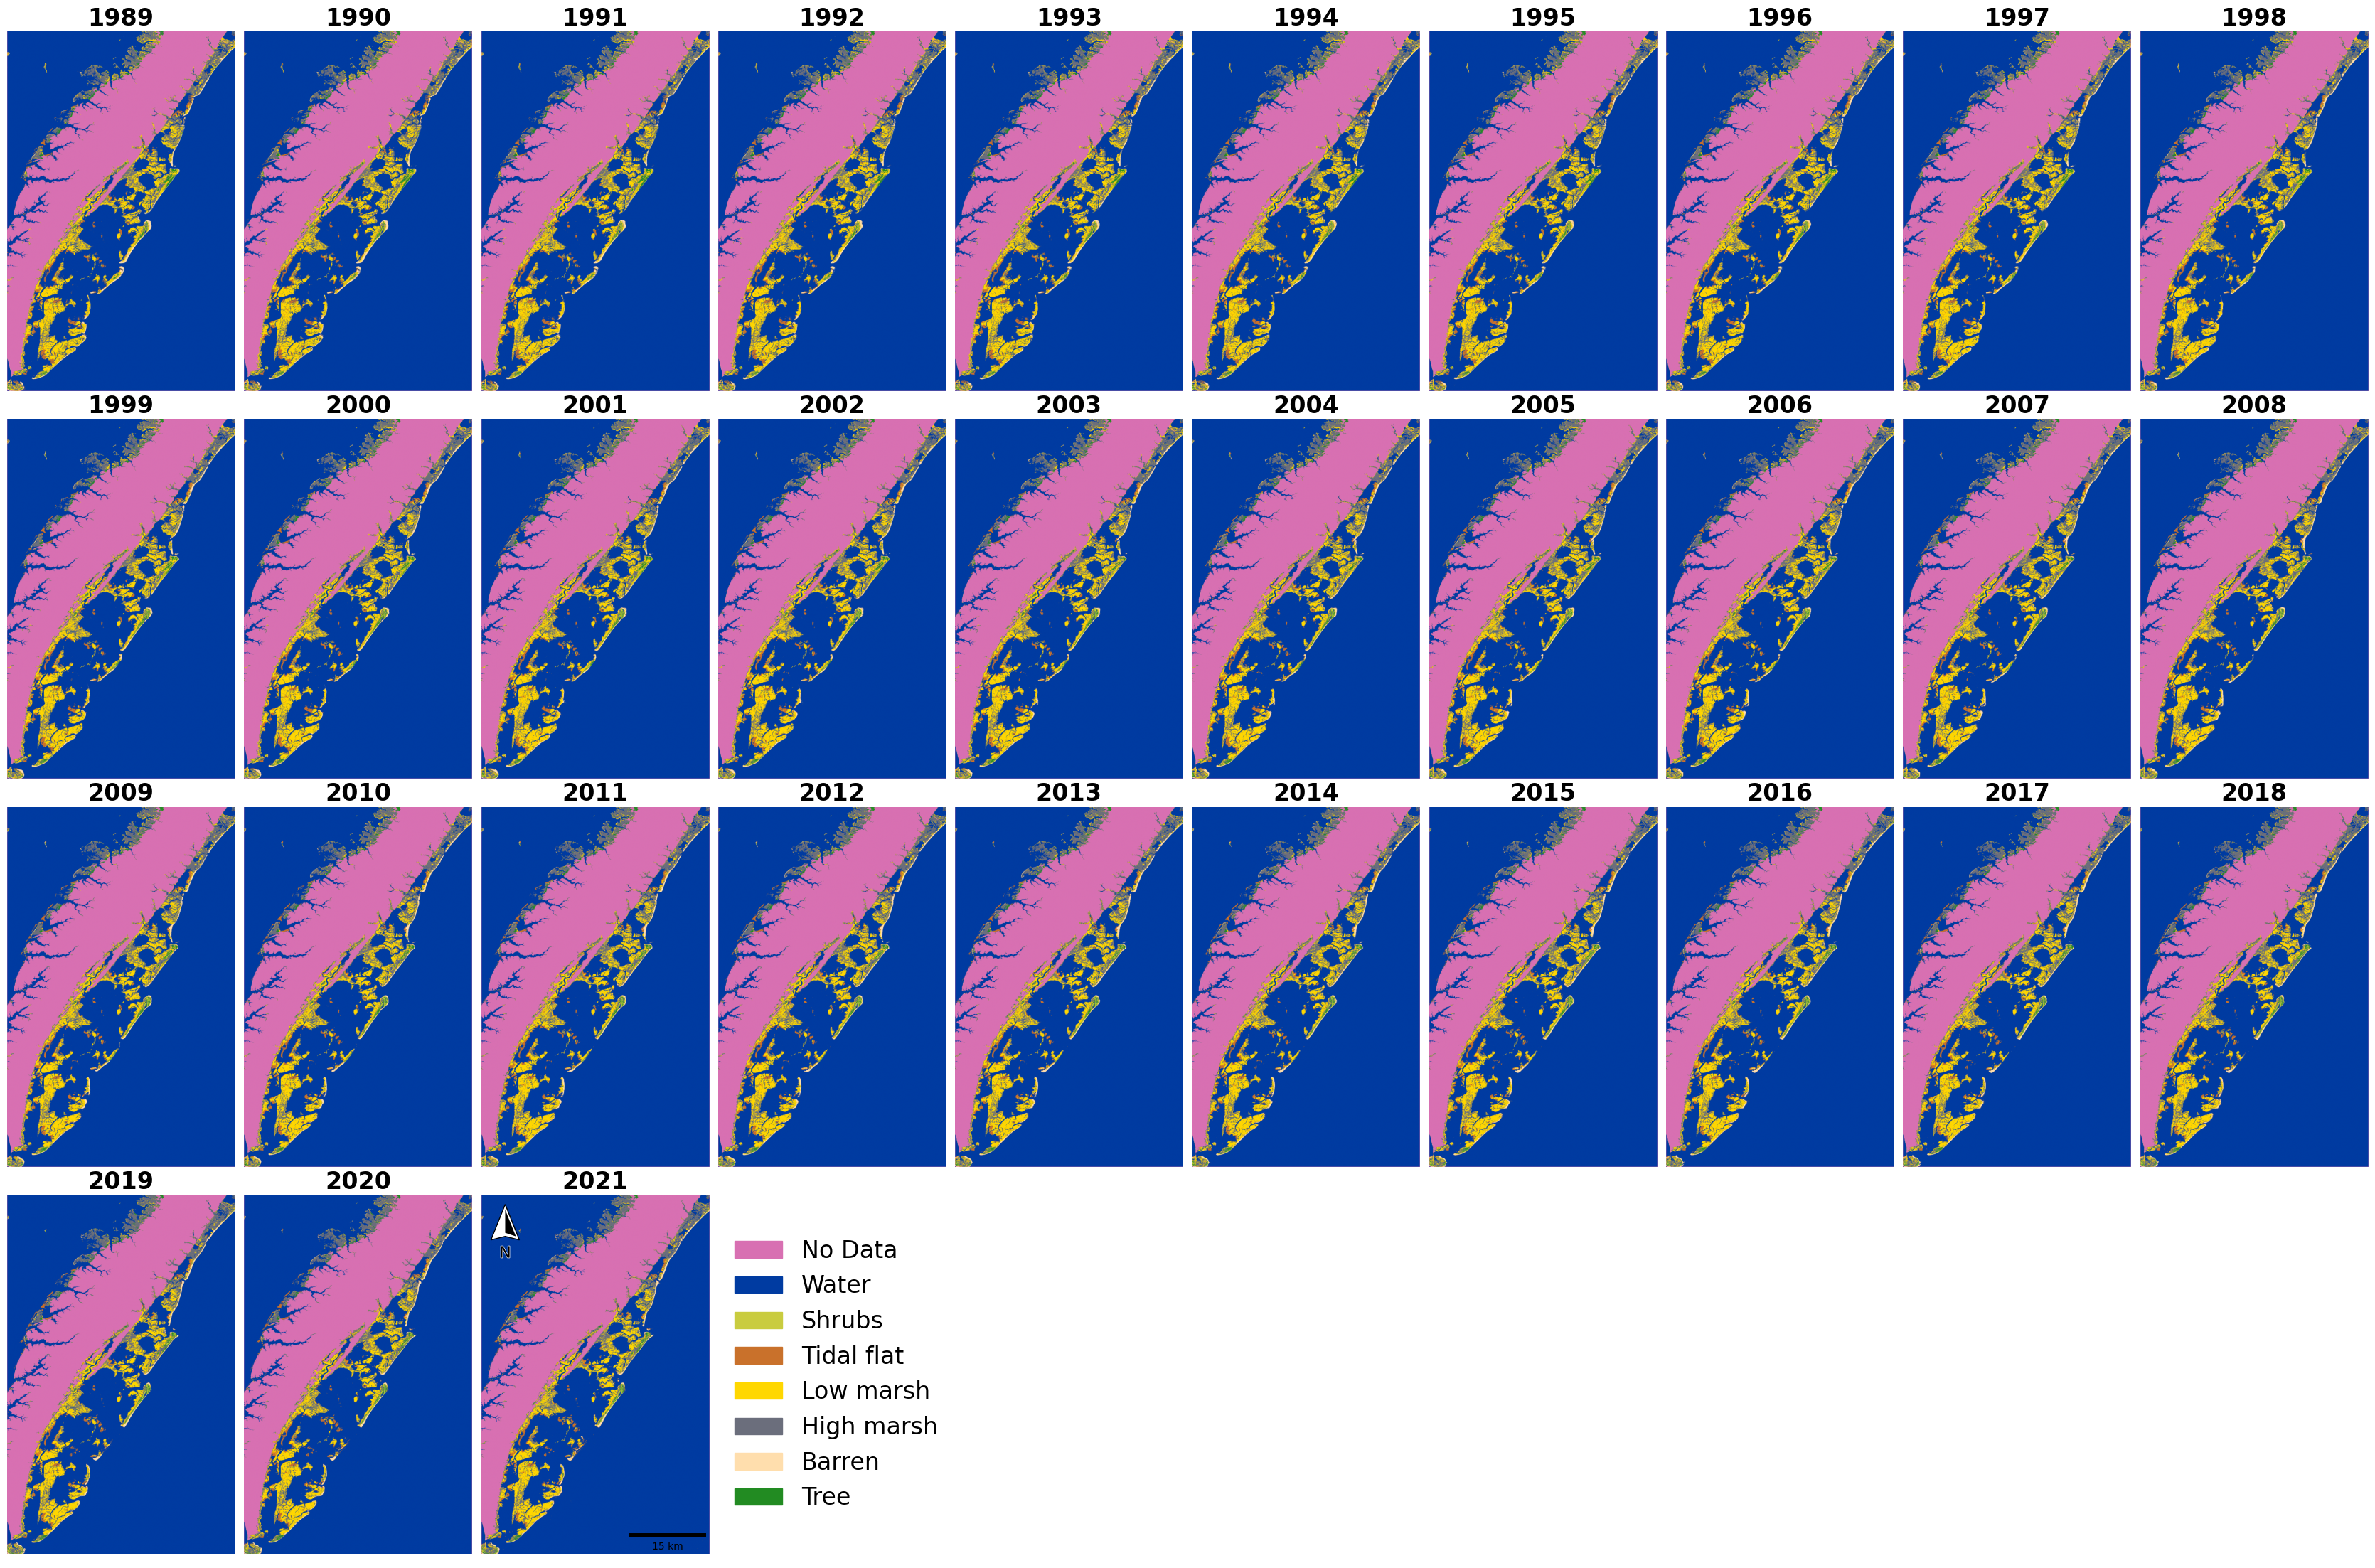

In [7]:
def compute_display_pixel_size_km(
    raster_path: str,
    downsample_divisor: int,
) -> float:
    """
    Compute horizontal resolution in kilometers per displayed pixel.

    Parameters
    ----------
    raster_path : str
        Path to a raster file used to derive spatial extent and CRS.
    downsample_divisor : int
        Integer factor used to downsample the raster width for display.

    Returns
    -------
    float
        Pixel size in kilometers for the downsampled display grid.
    """

    with rasterio.open(raster_path) as src:
        left, bottom, right, top = src.bounds
        lat_mid_src = (top + bottom) / 2.0

        to_ll = Transformer.from_crs(
            src.crs,
            "EPSG:4326",
            always_xy=True,
        )
        lon_l, lat_mid = to_ll.transform(
            left,
            lat_mid_src,
        )
        lon_r, _ = to_ll.transform(
            right,
            lat_mid_src,
        )

        geod = Geod(
            ellps="WGS84",
        )
        _, _, width_m = geod.inv(
            lon_l,
            lat_mid,
            lon_r,
            lat_mid,
        )

        cols_disp = max(
            1,
            src.width // downsample_divisor,
        )

        return (width_m / cols_disp) / 1_000


def plot_classified_images(
    class_map: Dict[int, Dict[str, str]],
    years: List[int],
    output_path: str,
    downsample_divisor: int = 1,
    panel_size: tuple = (4.0, 6.0),
    dx_km: Optional[float] = None,
    resampling_method: Resampling = Resampling.bilinear,
) -> None:
    """
    Plot classified rasters over time with legend, north arrow, and scale bar.

    Parameters
    ----------
    class_map : Dict[int, Dict[str, str]]
        Mapping from class ID to metadata with at least
        ``{"name": str, "color": str}`` for each class.
    years : List[int]
        List of years corresponding to each classified raster.
    output_path : str
        Directory where input rasters are stored and the figure is saved.
    downsample_divisor : int, optional
        Factor used to downsample raster dimensions for display, by default 1.
    panel_size : tuple, optional
        Width and height in inches for a single panel, by default (4.0, 6.0).
    dx_km : float, optional
        Pixel size in kilometers for the scale bar. If None, it is computed
        from the first raster, by default None.
    resampling_method : Resampling, optional
        Resampling method used when reading rasters, by default
        ``Resampling.bilinear``.

    Returns
    -------
    None
        This function saves a multi-panel figure to disk and shows the plot.
    """

    image_paths = sorted(
        glob.glob(
            os.path.join(
                output_path,
                "*masked.tif",
            ),
        ),
    )

    if not image_paths:
        raise ValueError("image_paths is empty.")

    if len(image_paths) != len(years):
        raise ValueError("image_paths and years must match in length.")

    # Configure subplot grid with a maximum number of columns.
    n_images = len(image_paths)
    max_cols = 10
    ncols = min(
        max_cols,
        n_images,
    )
    nrows = math.ceil(n_images / max_cols)

    fig, axs = plt.subplots(
        nrows,
        ncols,
        figsize=(
            panel_size[0] * ncols,
            panel_size[1] * nrows,
        ),
        sharey=True,
        constrained_layout=False,
    )
    plt.subplots_adjust(
        left=0.02,
        right=0.85,
        top=0.95,
        bottom=0.05,
        wspace=0.04,
        hspace=0.04,
    )

    if isinstance(axs, np.ndarray):
        axes = axs.ravel()
    else:
        axes = [axs]

    # Build colormap and normalization for class IDs.
    class_ids_sorted = sorted(class_map.keys())
    cmap = ListedColormap(
        [
            class_map[k]["color"]
            for k in class_ids_sorted
        ],
    )
    norm = BoundaryNorm(
        class_ids_sorted + [class_ids_sorted[-1] + 1],
        cmap.N,
    )

    # Derive km per displayed pixel when not provided.
    if dx_km is None:
        dx_km = compute_display_pixel_size_km(
            raster_path=image_paths[0],
            downsample_divisor=downsample_divisor,
        )

    # Plot each classified raster in its subplot.
    for i, (path, year) in enumerate(
        zip(
            image_paths,
            years,
        ),
    ):
        ax = axes[i]

        with rasterio.open(path) as src:
            h = max(
                1,
                src.height // downsample_divisor,
            )
            w = max(
                1,
                src.width // downsample_divisor,
            )
            data = src.read(
                1,
                out_shape=(
                    h,
                    w,
                ),
                resampling=resampling_method,
            )

        ax.imshow(
            data,
            cmap=cmap,
            norm=norm,
        )
        ax.set_title(
            f"{year}",
            fontweight="bold",
            fontsize=24,
        )
        ax.axis("off")

    # Disable unused axes when the grid is larger than the number of images.
    for j in range(
        n_images,
        len(axes),
    ):
        axes[j].axis("off")

    # Create legend using all class IDs on the last axis.
    legend_elements = [
        Rectangle(
            (0, 0),
            1,
            1,
            color=class_map[k]["color"],
            label=class_map[k]["name"],
        )
        for k in sorted(class_map.keys())
    ]

    last_ax = axes[n_images - 1]

    last_ax.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(
            1.02,
            0.5,
        ),
        frameon=False,
        fontsize=24,
    )

    # Add scale bar to the last subplot.
    scalebar = ScaleBar(
        dx=dx_km,
        units="km",
        length_fraction=0.35,
        location="lower right",
        scale_loc="bottom",
        color="black",
        box_alpha=0,
    )
    axes[n_images - 1].add_artist(
        scalebar,
    )

    # Add north arrow to the last subplot.
    north_arrow(
        axes[n_images - 1],
        location="upper left",
        shadow=False,
        rotation={
            "degrees": 0,
        },
    )

    # Save figure to disk.
    out_fig = os.path.join(
        output_path,
        "plot_input_maps.jpeg",
    )
    plt.savefig(
        out_fig,
        format="jpeg",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()
    plt.close()

plot_classified_images(
    class_map=class_labels_dict,
    years=years,
    output_path=output_path,
)

## **3.Class distribution over time**


---


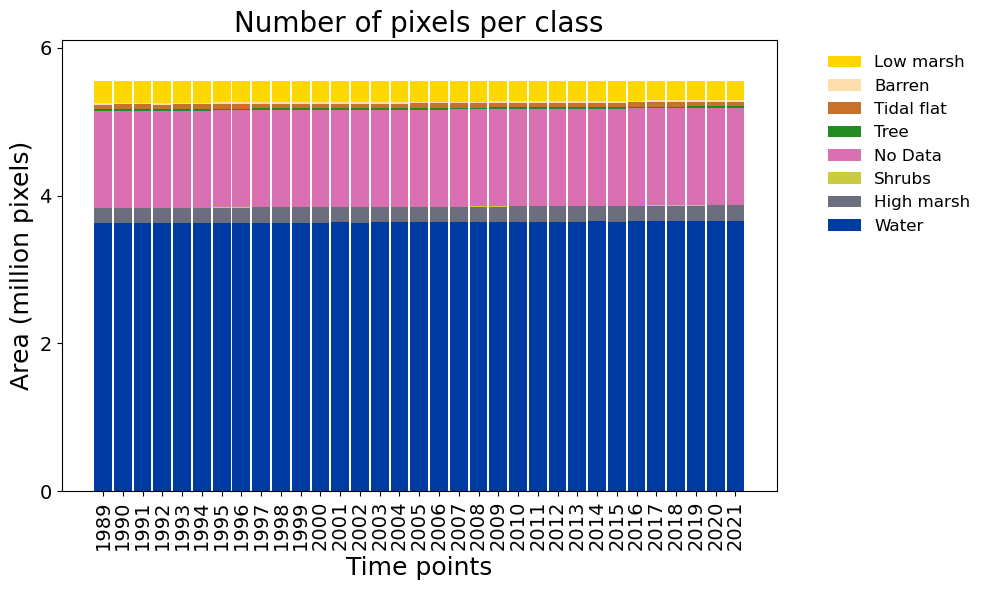

In [8]:
# Collect masked rasters
image_paths = sorted(
    glob.glob(
        os.path.join(
            output_path,
            "*masked.tif",
        ),
    ),
)

if len(image_paths) != len(years):
    raise ValueError(
        f"Found {len(image_paths)} masked rasters but len(years) == {len(years)}.",
    )

records: list[dict] = []

# Count pixels per class (excluding 0 / Background) for each year
for year, path in zip(
    years,
    image_paths,
):
    with rasterio.open(
        path,
    ) as src:
        data = src.read(
            1,
        )

    values, counts = np.unique(
        data,
        return_counts=True,
    )

    for value, count in zip(
        values,
        counts,
    ):
        value = int(value)
        # if value == 0:
        #     continue
        if value not in class_labels_dict:
            continue

        records.append(
            {
                "Year": year,
                "ClassID": value,
                "ClassName": class_labels_dict[value]["name"],
                "Pixels": int(count),
            },
        )

df_pixels = pd.DataFrame(
    records,
)

# Pivot table: rows = years, columns = classes, values = pixel counts
pivot_pixels = (
    df_pixels.pivot_table(
        index="Year",
        columns="ClassName",
        values="Pixels",
        aggfunc="sum",
    )
    .fillna(0.0)
    .astype(float)
)

years_array = pivot_pixels.index.values

# Automatic scale for y-axis
max_val = pivot_pixels.to_numpy().max()

if max_val >= 1_000_000:
    scale_factor = 1_000_000
    y_label = "Area (million pixels)"
elif max_val >= 1_000:
    scale_factor = 1_000
    y_label = "Area (thousand pixels)"
elif max_val >= 100:
    scale_factor = 100
    y_label = "Area (hundred pixels)"
else:
    scale_factor = 1
    y_label = "Area (pixels)"

pivot_scaled = pivot_pixels / scale_factor

# # Class IDs and color map
# class_ids_plot = [
#     class_id
#     for class_id in sorted(class_labels_dict.keys())
#     if class_id != 0
# ]

# Class IDs and color map
class_ids_plot = sorted(
    class_labels_dict.keys(),
)

color_map = {
    class_labels_dict[class_id]["name"]: class_labels_dict[class_id]["color"]
    for class_id in class_ids_plot
}

# Sort classes by net change (last - first)
first_year = years_array[0]
last_year = years_array[-1]

net_change_per_class = (
    pivot_scaled.loc[last_year]
    - pivot_scaled.loc[first_year]
)

# Order for stacking:
#   bottom = largest gainers, top = largest losers
classes_for_stack = list(
    net_change_per_class.sort_values(
        ascending=False,
    ).index,
)

# Order for legend:
#   top = largest losers, bottom = largest gainers
classes_for_legend = list(
    reversed(classes_for_stack),
)

# Stacked bar chart
fig, ax = plt.subplots(
    figsize=(
        10,
        6,
    ),
)

x = np.arange(
    len(years_array),
)
width = 0.9

base = np.zeros(
    len(years_array),
    dtype=float,
)

patches_by_class: dict[str, plt.Artist] = {}

for cls in classes_for_stack:
    if cls not in pivot_scaled.columns:
        continue

    values_cls = pivot_scaled[cls].reindex(
        years_array,
        fill_value=0.0,
    ).values

    bars = ax.bar(
        x,
        values_cls,
        bottom=base,
        width=width,
        label=cls,
        color=color_map[cls],
    )
    patches_by_class[cls] = bars[0]
    base += values_cls

# X-axis ticks and adaptive rotation
ax.set_xticks(
    x,
)
ax.set_xticklabels(
    years_array,
)
n_labels = len(years_array)
if n_labels <= 6:
    rotation = 0
    ha = "center"
elif n_labels <= 12:
    rotation = 45
    ha = "right"
else:
    rotation = 90
    ha = "center"

plt.setp(
    ax.get_xticklabels(),
    rotation=rotation,
    ha=ha,
)

ax.tick_params(
    axis="both",
    labelsize=14,
)

ax.set_ylabel(
    y_label,
    fontsize=18,
)
ax.set_xlabel(
    "Time points",
    fontsize=18,
)
ax.set_title(
    "Number of pixels per class",
    fontsize=20,
)

# Y-axis limit based on stacked maximum
y_max_scaled = base.max() * 1.1 if base.max() > 0 else 1.0
ax.set_ylim(
    0,
    y_max_scaled,
)
ax.yaxis.set_major_locator(
    ticker.MaxNLocator(
        nbins=5,
        integer=True,

    ),
)
ax.yaxis.set_major_formatter(
    ticker.FormatStrFormatter(
        "%d",
    ),
)

# Legend: largest losers at the top, largest gainers at the bottom
handles = [
    patches_by_class[cls]
    for cls in classes_for_legend
    if cls in patches_by_class
]
labels = [
    cls
    for cls in classes_for_legend
    if cls in patches_by_class
]

ax.legend(
    handles,
    labels,
    bbox_to_anchor=(
        1.05,
        1.0,
    ),
    loc="upper left",
    frameon=False,
    fontsize=12,
)

plt.tight_layout()
plt.show()

In [9]:
# Export pixel counts per time point to CSV
csv_output_path = os.path.join(
    output_path,
    "pixels_per_class_per_year.csv",
)

pivot_pixels.to_csv(
    csv_output_path,
    index_label="Year",
)

print(
    f"Pixel counts table saved to: {csv_output_path}",
)

Pixel counts table saved to: /Users/antoniofonseca/Dataset/vcr/outputs/pixels_per_class_per_year.csv


## **4.Generate the Transition Matrix**


---
In this section, the computer code will generate four different transition matrices. The first one is related to each time interval. The second one is the transition matrix for the temporal extent, which is represented for the first and last time point of the time extent. The third one is a transition matrix that represents the sum of all time intervals. And the last transition matrix is the alternation matrix, which is the sum matrix minus the extent matrix.

Before generate the transition matrix, the computer code will analyze the presence of 0, NULL and NA value in all maps. If there is a presence of one of these values, the computer code will create a mask with these values and will remove all the pixels in the same position in all maps and years.

All the transition matrix will be salved in yput output folder in the ".csv" format.

In [10]:
# Generate the Transition Matrix
def generate_mask_and_flatten_rasters(
    output_path: str,
    suffix: str = "_masked.tif",
) -> List[np.ndarray]:
    """
    Read rasters by suffix, mask zeros/NaN/nodata, and flatten valid values.

    Parameters
    ----------
    output_path : str
        Folder containing rasters.
    suffix : str, optional
        Filename suffix to select rasters, by default "_masked.tif".

    Returns
    -------
    List[np.ndarray]
        List of flattened arrays (one per raster).
    """

    # Collect and sort raster paths
    image_paths = [
        os.path.join(
            output_path,
            f,
        )
        for f in os.listdir(output_path)
        if f.endswith(suffix)
    ]
    image_paths.sort()

    # Containers for raster data and individual masks
    all_data: List[np.ndarray] = []
    all_masks: List[np.ndarray] = []

    # Read rasters and build per-raster masks
    for path in tqdm(
        image_paths,
        desc="Reading and masking rasters",
        unit="raster",
    ):
        with rasterio.open(path) as src:
            data = src.read(1)
            mask = (
                (data == noData_value)
                | (data == src.nodata)
                | np.isnan(data)
            )
            all_masks.append(mask)
            all_data.append(data)

    # Union of masks across all rasters
    combined_mask = np.any(
        all_masks,
        axis=0,
    )

    # Flatten non-masked values for each raster
    flattened = [
        data[~combined_mask].flatten()
        if np.any(combined_mask)
        else data.flatten()
        for data in all_data
    ]

    return flattened


# Alias for readability
transition_matrix = confusion_matrix


def generate_all_matrices(
    output_path: str,
    suffix: str = "_masked.tif",
) -> tuple[list[int], np.ndarray]:
    """
    Generate interval, extent, sum, and alternation transition matrices.

    Parameters
    ----------
    output_path : str
        Directory containing input rasters and where CSV outputs are saved.
    suffix : str, optional
        Filename suffix used to select input rasters, by default "_masked.tif".

    Returns
    -------
    tuple[list[int], np.ndarray]
        List of years and array of all class labels present in the rasters.
    """

    global years

    # Load processed and flattened raster data
    flattened_data = generate_mask_and_flatten_rasters(
        output_path=output_path,
        suffix=suffix,
    )

    # Validate that the number of rasters matches the number of years
    if len(years) != len(flattened_data):
        raise ValueError(
            f"Mismatch: {len(years)} years vs {len(flattened_data)} rasters",
        )

    # Derive the set of all classes present across all rasters
    all_classes = np.unique(
        np.concatenate(flattened_data),
    ).astype(int)

    # Compute and save interval-by-interval transition matrices
    for i in tqdm(
        range(len(flattened_data) - 1),
        desc="Interval matrices",
        unit="interval",
    ):
        cm = transition_matrix(
            flattened_data[i],
            flattened_data[i + 1],
            labels=all_classes,
        )
        out_csv = os.path.join(
            output_path,
            f"transition_matrix_{years[i]}-{years[i + 1]}.csv",
        )
        pd.DataFrame(
            cm,
            index=all_classes,
            columns=all_classes,
        ).to_csv(out_csv)

    # Compute and save extent matrix (first vs last year)
    extent_matrix = transition_matrix(
        flattened_data[0],
        flattened_data[-1],
        labels=all_classes,
    )
    out_csv = os.path.join(
        output_path,
        f"transition_matrix_extent_{years[0]}-{years[-1]}.csv",
    )
    pd.DataFrame(
        extent_matrix,
        index=all_classes,
        columns=all_classes,
    ).to_csv(out_csv)

    # Compute and save sum of all interval matrices
    n = len(all_classes)
    sum_matrix = np.zeros(
        (n, n),
        dtype=int,
    )
    for i in tqdm(
        range(len(flattened_data) - 1),
        desc="Summing interval matrices",
        unit="interval",
    ):
        sum_matrix += transition_matrix(
            flattened_data[i],
            flattened_data[i + 1],
            labels=all_classes,
        )
    out_csv = os.path.join(
        output_path,
        f"transition_matrix_sum_{years[0]}-{years[-1]}.csv",
    )
    pd.DataFrame(
        sum_matrix,
        index=all_classes,
        columns=all_classes,
    ).to_csv(out_csv)

    # Compute and save alternation matrix (sum minus extent)
    alternation_matrix = sum_matrix - extent_matrix
    out_csv = os.path.join(
        output_path,
        f"transition_matrix_alternation_{years[0]}-{years[-1]}.csv",
    )
    pd.DataFrame(
        alternation_matrix,
        index=all_classes,
        columns=all_classes,
    ).to_csv(out_csv)

    return years, all_classes


def main(
    output_path: str,
) -> None:
    """
    Run the transition-matrix generation workflow.

    Parameters
    ----------
    output_path : str
        Directory containing rasters and where CSV outputs are saved.

    Returns
    -------
    None
    """

    # Ensure output folder exists
    os.makedirs(
        output_path,
        exist_ok=True,
    )

    # Build all matrices
    print("Generating transition matrices...")
    years_out, all_classes = generate_all_matrices(
        output_path=output_path,
    )

    print(f"Detected classes: {all_classes}")
    print(f"Matrices saved in: {output_path}")


if __name__ == "__main__":
    main(
        output_path=output_path,
    )

Generating transition matrices...


Summing interval matrices: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  9.25interval/s]

Detected classes: [0 1 2 3 4 5 6 7]
Matrices saved in: /Users/antoniofonseca/Dataset/vcr/outputs


## **5.Heat Maps**


---

### 5.1 Functions

In [14]:
# Basic checks for global inputs used in the matrices
assert isinstance(
    years,
    (
        list,
        tuple,
    ),
) and len(years) >= 2, "`years` missing or invalid."

assert isinstance(
    output_path,
    str,
) and output_path, "`output_path` missing or invalid."

assert isinstance(
    class_labels_dict,
    dict,
) and class_labels_dict, "`class_labels_dict` missing or invalid."

Y0, Y1 = years[0], years[-1]
OUT_DIR = Path(output_path)

CSV_SUM = OUT_DIR / f"transition_matrix_sum_{Y0}-{Y1}.csv"
CSV_EXT = OUT_DIR / f"transition_matrix_extent_{Y0}-{Y1}.csv"
CSV_ALT = OUT_DIR / f"transition_matrix_alternation_{Y0}-{Y1}.csv"
CSV_EXC = OUT_DIR / f"transition_matrix_exchange_FROM_SUM_{Y0}-{Y1}.csv"

for path_csv in (
    CSV_SUM,
    CSV_EXT,
    CSV_ALT,
):
    if not path_csv.exists():
        raise FileNotFoundError(
            f"Missing CSV: {path_csv}",
        )

print("Found base CSVs.")


def load_square_matrix(
    csv_path: Path,
) -> pd.DataFrame:
    """
    Load a square transition matrix from CSV and align row/column labels.

    Parameters
    ----------
    csv_path : Path
        Path to a CSV file where the first column and the header row
        contain class IDs (or labels), and the remaining cells contain
        transition counts.

    Returns
    -------
    pd.DataFrame
        Square DataFrame with string labels on both rows and columns.
        When row and column labels differ, their union is used and
        missing cells are filled with 0.0.
    """
    df = pd.read_csv(
        csv_path,
        index_col=0,
    )
    df.index = df.index.map(str)
    df.columns = df.columns.map(str)

    if list(df.index) != list(df.columns):
        labels = sorted(
            set(df.index).union(df.columns),
            key=lambda x: int(x),
        )
        df = df.reindex(
            index=labels,
            columns=labels,
        ).fillna(0.0)

    if df.shape[0] != df.shape[1]:
        raise ValueError(
            f"Matrix not square after alignment: {csv_path}",
        )

    return df


def label_id_to_name(
    labels: Iterable[str],
) -> list[str]:
    """
    Map class ID strings to human-readable names using ``class_labels_dict``.

    Parameters
    ----------
    labels : iterable of str
        Class IDs as strings (e.g. ``["0", "1", "2"]``) taken from
        matrix indices or columns.

    Returns
    -------
    list of str
        List of class names where each ID is mapped to:
        ``class_labels_dict[id]["rename"]`` if present,
        otherwise ``class_labels_dict[id]["name"]``, and finally
        the original ID string if the ID is not found.
    """
    id_to_name = {
        int(k): v.get(
            "rename",
            v.get(
                "name",
                str(k),
            ),
        )
        for k, v in class_labels_dict.items()
    }

    names: list[str] = []
    for lab in labels:
        try:
            cid = int(str(lab))
            names.append(
                id_to_name.get(
                    cid,
                    str(lab),
                ),
            )
        except Exception:
            names.append(str(lab))

    return names


def exchange_from_T(
    dfT: pd.DataFrame,
) -> pd.DataFrame:
    """
    Compute the bilateral exchange matrix from a transition matrix.

    Parameters
    ----------
    dfT : pd.DataFrame
        Square transition matrix where ``T_ij`` is the number of pixels
        transitioning from class ``i`` (row) to class ``j`` (column).

    Returns
    -------
    pd.DataFrame
        Square exchange matrix ``E`` with the same index/columns as
        ``dfT``, where::

            E(i, j) = min(T_ij, T_ji)  for i != j
            E(i, i) = 0
    """
    T = dfT.values.astype(float)
    E = np.minimum(
        T,
        T.T,
    )
    np.fill_diagonal(
        E,
        0.0,
    )

    return pd.DataFrame(
        E,
        index=dfT.index,
        columns=dfT.columns,
    )


def compute_net_change_from_sum(
    df_sum: pd.DataFrame,
) -> pd.Series:
    """
    Compute net change per class from a SUM transition matrix.

    Parameters
    ----------
    df_sum : pd.DataFrame
        Square transition matrix representing total transitions over
        the full time span, including persistence on the diagonal.

    Returns
    -------
    pd.Series
        Net change for each class (index aligned with ``df_sum.index``),
        computed as::

            net_change(j) = gains(j) - losses(j)

        where gains(j) is the sum of column j (i -> j) excluding the
        diagonal, and losses(j) is the sum of row j (j -> k) excluding
        the diagonal.
    """
    M = df_sum.values.astype(float).copy()

    # Remove persistence on the diagonal for the calculation
    np.fill_diagonal(
        M,
        0.0,
    )

    gains = M.sum(
        axis=0,
    )
    losses = M.sum(
        axis=1,
    )

    net_change = gains - losses

    return pd.Series(
        net_change,
        index=df_sum.index,
    )


def reorder_matrices_by_net_change(
    df_sum: pd.DataFrame,
    df_ext: pd.DataFrame,
    df_alt: pd.DataFrame,
    df_exc: pd.DataFrame,
) -> tuple[
    pd.DataFrame,
    pd.DataFrame,
    pd.DataFrame,
    pd.DataFrame,
]:
    """
    Reorder rows and columns of all matrices using net change from ``df_sum``.

    Parameters
    ----------
    df_sum : pd.DataFrame
        SUM transition matrix.
    df_ext : pd.DataFrame
        Extent matrix for the same classes.
    df_alt : pd.DataFrame
        Alternation matrix for the same classes.
    df_exc : pd.DataFrame
        Exchange matrix (e.g. derived from SUM) for the same classes.

    Returns
    -------
    tuple of pd.DataFrame
        Tuple ``(df_sum_ord, df_ext_ord, df_alt_ord, df_exc_ord)`` where
        all matrices share the same ordering, with:

        - largest losers (most negative net change) at the top,
        - largest gainers (most positive net change) at the bottom.
    """
    net_change = compute_net_change_from_sum(
        df_sum=df_sum,
    )
    order_labels = (
        net_change.sort_values(
            ascending=True,
        )
        .index.tolist()
    )

    def _reorder(
        df: pd.DataFrame,
    ) -> pd.DataFrame:
        return df.reindex(
            index=order_labels,
            columns=order_labels,
        )

    return (
        _reorder(df_sum),
        _reorder(df_ext),
        _reorder(df_alt),
        _reorder(df_exc),
    )


def annotate_heatmap(
    ax: plt.Axes,
    M: np.ndarray,
    fontsize: int = 8,
) -> None:
    """
    Annotate a heatmap with integer cell values and adaptive text color.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axes object on which the heatmap was drawn.
    M : np.ndarray
        2D array of original (unscaled) values used for annotations.
    fontsize : int, optional
        Font size for the cell labels.

    Notes
    -----
    - Diagonal cells are always annotated in white to contrast with
      the black diagonal fill.
    - Off-diagonal cells with large positive or negative magnitude
      are also annotated in white; thresholds are computed ignoring
      the diagonal.
    """
    if M.size == 0:
        return

    M_off = M.copy()
    np.fill_diagonal(
        M_off,
        np.nan,
    )
    data_off = M_off[np.isfinite(M_off)]

    has_pos = np.any(data_off > 0)
    has_neg = np.any(data_off < 0)

    max_pos = float(np.nanmax(data_off[data_off > 0])) if has_pos else 0.0
    min_neg = float(np.nanmin(data_off[data_off < 0])) if has_neg else 0.0

    thresh_pos = 0.5 * max_pos if has_pos else np.inf
    thresh_neg = 0.5 * min_neg if has_neg else -np.inf

    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            v = float(M[i, j])
            txt = f"{int(round(v))}"

            if i == j:
                color = "white"
            else:
                if (
                    has_pos
                    and v >= thresh_pos
                ) or (
                    has_neg
                    and v <= thresh_neg
                ):
                    color = "white"
                else:
                    color = "black"

            ax.text(
                j,
                i,
                txt,
                ha="center",
                va="center",
                fontsize=fontsize,
                color=color,
                clip_on=True,
            )


def _unit_label(
    suffix: str,
    base_label: str = "Number of pixels",
) -> str:
    """
    Build a descriptive label for the colorbar based on a unit suffix.

    Parameters
    ----------
    suffix : str
        Unit suffix, e.g. ``""``, ``"k"``, ``"M"``, ``"B"``, ``"T"``.
    base_label : str, optional
        Base text used when ``suffix == ""``.

    Returns
    -------
    str
        Human-readable label, e.g. ``"Millions of pixels"`` when
        ``suffix == "M"``.
    """
    mapping = {
        "": base_label,
        "k": "Thousands of pixels",
        "M": "Millions of pixels",
        "B": "Billions of pixels",
        "T": "Trillions of pixels",
    }

    return mapping.get(
        suffix,
        f"{base_label} ({suffix})",
    )


def _unit_formatter(
    factor: float,
    suffix: str,
    decimals: int = 1,
) -> mticker.FuncFormatter:
    """
    Build a tick formatter that scales values and appends a suffix.

    Parameters
    ----------
    factor : float
        Divisor used to scale raw values (e.g. 1e6 for millions).
    suffix : str
        Suffix appended to the formatted value, e.g. ``"M"`` or ``"km"``.
    decimals : int, optional
        Number of decimal places.

    Returns
    -------
    matplotlib.ticker.FuncFormatter
        Formatter that can be assigned to a colorbar or axis.
    """
    fmt = f"{{:.{decimals}f}}{suffix}"

    def _fmt(
        x: float,
        pos: int,
    ) -> str:
        return fmt.format(x / factor)

    return mticker.FuncFormatter(_fmt)


def _compute_vlimits(
    M: np.ndarray,
    vmin: float | None,
    vmax: float | None,
    vmax_percentile: float | None,
) -> tuple[float, float]:
    """
    Compute ``vmin`` and ``vmax`` with optional upper-percentile clipping.

    Parameters
    ----------
    M : np.ndarray
        Matrix of values used for plotting.
    vmin : float or None
        Lower bound for the color scale. If None, the minimum of ``M``
        (ignoring NaNs) is used.
    vmax : float or None
        Upper bound for the color scale. If None and
        ``vmax_percentile`` is None, the maximum of ``M`` is used.
    vmax_percentile : float or None
        If not None, use this percentile (e.g. 99.5) of the finite
        values in ``M`` as the upper bound, clipping the top tail.

    Returns
    -------
    (float, float)
        Tuple ``(vmin_eff, vmax_eff)`` with valid bounds (``vmax_eff``
        is adjusted to be greater than ``vmin_eff`` if needed).
    """
    data = M[np.isfinite(M)]
    lo = float(np.nanmin(data)) if vmin is None else float(vmin)

    if vmax_percentile is not None:
        hi = float(
            np.nanpercentile(
                data,
                vmax_percentile,
            ),
        )
    else:
        hi = float(np.nanmax(data)) if vmax is None else float(vmax)

    if hi <= lo:
        hi = lo + 1.0

    return lo, hi


def _make_norm(
    scale: str,
    vmin: float,
    vmax: float,
    gamma: float = 0.5,
) -> mcolors.Normalize:
    """
    Build a Matplotlib normalization according to the requested scale.

    Parameters
    ----------
    scale : str
        Normalization type: ``"linear"``, ``"log"``, or ``"power"``.
    vmin : float
        Lower bound for the normalization.
    vmax : float
        Upper bound for the normalization.
    gamma : float, optional
        Exponent used for ``"power"`` scaling (PowerNorm).

    Returns
    -------
    matplotlib.colors.Normalize
        Normalization instance suitable for ``imshow`` or similar.
    """
    scale = scale.lower()

    if scale == "log":
        vmin_eff = max(
            vmin,
            1e-9,
        )
        return mcolors.LogNorm(
            vmin=vmin_eff,
            vmax=vmax,
        )

    if scale == "power":
        return mcolors.PowerNorm(
            gamma=gamma,
            vmin=vmin,
            vmax=vmax,
        )

    return mcolors.Normalize(
        vmin=vmin,
        vmax=vmax,
    )

def plot_heatmap(
    df: pd.DataFrame,
    title: str,
    save_path: Path | None = None,
    figsize: Tuple[float, float] | None = None,
    cmap: str = "YlOrRd",
    vmin: float = 0.0,
    vmax: float | None = None,
    rotate_xticks_deg: int = 90,
    cbar_label: str = "Number of pixels",
    annotate: bool = True,
    cell_size_inch: float = 0.8,
    tick_fontsize: int | None = None,
    ann_fontsize: int = 8,
    cbar_fraction: float = 0.025,
    cbar_pad: float = 0.02,
    tick_fontsize_x: int | None = None,
    tick_fontsize_y: int | None = None,
    axis_label_fontsize: int | None = None,
    title_fontsize: int | None = None,
) -> None:
    """
    Plot a square matrix as a heatmap with integer annotations.

    The function applies a black overlay on the diagonal, adaptive color
    scaling for positive and negative values, and formats the colorbar
    units (e.g., k for thousands, M for millions).
    """
    if (
        tick_fontsize_x is None
    ) or (
        tick_fontsize_y is None
    ):
        raise ValueError(
            "Set `tick_fontsize_x` and `tick_fontsize_y` explicitly in the call.",
        )

    if axis_label_fontsize is None:
        axis_label_fontsize = 12

    if title_fontsize is None:
        title_fontsize = 14

    labels = list(
        df.index,
    )
    M = df.values.astype(
        float,
    )

    # Remove diagonal for color scaling calculation
    M_scale = M.copy()
    np.fill_diagonal(
        M_scale,
        0.0,
    )
    finite_vals = M_scale[
        np.isfinite(
            M_scale,
        )
    ]

    # Logical checks for negative values and scaling
    if finite_vals.size == 0:
        has_negative = False
        vmin_eff = 0.0
        vmax_eff = 1.0
    else:
        has_negative = float(
            np.nanmin(
                finite_vals,
            ),
        ) < 0.0
        min_val = float(
            np.nanmin(
                finite_vals,
            ),
        )
        max_val = float(
            np.nanmax(
                finite_vals,
            ),
        )

        if has_negative:
            vmin_eff = min_val
            vmax_eff = max_val
            if vmin_eff == vmax_eff:
                vmax_eff = vmin_eff + 1.0
        else:
            vmin_eff = vmin
            vmax_eff = (
                float(
                    max_val,
                )
                if vmax is None
                else float(
                    vmax,
                )
            )
            if vmin_eff == vmax_eff:
                vmax_eff = vmin_eff + 1.0

    nrows, ncols = df.shape
    if figsize is None:
        figsize = (
            cell_size_inch * ncols,
            cell_size_inch * nrows,
        )

    fig, ax = plt.subplots(
        figsize=figsize,
        constrained_layout=True,
    )

    # Rendering layers
    if has_negative:
        # Positive values (>= 0)
        M_pos = np.where(
            M < 0.0,
            0.0,
            M,
        )
        norm_pos = mcolors.Normalize(
            vmin=0.0,
            vmax=vmax_eff,
        )
        ax.imshow(
            M_pos,
            aspect="equal",
            cmap=plt.cm.YlOrRd,
            norm=norm_pos,
        )

        # Negative values (< 0)
        M_neg = np.ma.masked_where(
            M >= 0.0,
            M,
        )
        norm_neg = mcolors.Normalize(
            vmin=vmin_eff,
            vmax=0.0,
        )
        ax.imshow(
            M_neg,
            aspect="equal",
            cmap=plt.cm.Blues_r,
            norm=norm_neg,
        )
    else:
        norm_pos = mcolors.Normalize(
            vmin=vmin_eff,
            vmax=vmax_eff,
        )
        ax.imshow(
            M,
            aspect="equal",
            cmap=plt.cm.YlOrRd,
            norm=norm_pos,
        )

    # Black diagonal overlay
    diag_mask = np.zeros_like(
        M,
        dtype=bool,
    )
    np.fill_diagonal(
        diag_mask,
        True,
    )
    M_diag = np.ma.masked_where(
        ~diag_mask,
        np.ones_like(
            M,
        ),
    )
    black_cmap = mcolors.ListedColormap(
        [
            "black",
        ],
    )
    ax.imshow(
        M_diag,
        aspect="equal",
        cmap=black_cmap,
        vmin=0,
        vmax=1,
    )

    # Ticks and Labels
    ax.set_xticks(
        range(
            len(
                labels,
            ),
        ),
    )
    ax.set_yticks(
        range(
            len(
                labels,
            ),
        ),
    )
    
    tick_names = label_id_to_name(
        labels,
    )

    fx = tick_fontsize if tick_fontsize is not None else tick_fontsize_x
    fy = tick_fontsize if tick_fontsize is not None else tick_fontsize_y

    ax.set_xticklabels(
        tick_names,
        rotation=rotate_xticks_deg,
        fontsize=fx,
    )
    ax.set_yticklabels(
        tick_names,
        fontsize=fy,
    )

    ax.set_xlabel(
        "To class",
        fontsize=axis_label_fontsize,
    )
    ax.set_ylabel(
        "From class",
        fontsize=axis_label_fontsize,
    )
    ax.set_title(
        title,
        fontsize=title_fontsize,
    )

    # Colorbar construction
    n_bar = 256
    vals = np.linspace(
        vmin_eff,
        vmax_eff,
        n_bar,
    )
    colors_bar = np.zeros(
        (
            n_bar,
            4,
        ),
        dtype=float,
    )

    for i, v in enumerate(
        vals,
    ):
        if has_negative and v < 0.0:
            t = (v - vmin_eff) / (0.0 - vmin_eff)
            colors_bar[i, :] = plt.cm.Blues_r(t)
        else:
            t = max(0.0, v) / vmax_eff if vmax_eff > 0.0 else 0.0
            colors_bar[i, :] = plt.cm.YlOrRd(t)

    cmap_bar = mcolors.ListedColormap(
        colors_bar,
    )
    norm_bar = mcolors.Normalize(
        vmin=vmin_eff,
        vmax=vmax_eff,
    )

    sm = plt.cm.ScalarMappable(
        cmap=cmap_bar,
        norm=norm_bar,
    )
    sm.set_array(
        [],
    )

    cbar = plt.colorbar(
        sm,
        ax=ax,
        fraction=cbar_fraction,
        pad=cbar_pad,
    )

    # Adaptive units
    max_abs = float(np.nanmax(np.abs(finite_vals))) if finite_vals.size > 0 else 0.0

    if max_abs >= 1_000_000:
        factor, suffix = 1_000_000.0, "M"
    elif max_abs >= 1_000:
        factor, suffix = 1_000.0, "k"
    elif max_abs >= 100:
        factor, suffix = 100.0, "hundreds"
    else:
        factor, suffix = 1.0, ""

    cbar.formatter = _unit_formatter(
        factor=factor,
        suffix="",
        decimals=0,
    )
    cbar.set_label(
        _unit_label(
            suffix,
            base_label=cbar_label,
        ),
        rotation=270,
        labelpad=14,
    )

    if annotate:
        annotate_heatmap(
            ax=ax,
            M=M,
            fontsize=ann_fontsize,
        )

    if save_path is not None:
        fig.savefig(
            save_path,
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()

Found base CSVs.


### 5.2 Compute Exchange matrix

In [15]:
# Load SUM, EXTENT, and ALTERNATION matrices from CSV files
df_sum = load_square_matrix(
    CSV_SUM,
)
df_ext = load_square_matrix(
    CSV_EXT,
)
df_alt = load_square_matrix(
    CSV_ALT,
)

# Compute EXCHANGE matrix from SUM and save to CSV
df_exc = exchange_from_T(
    dfT=df_sum,
)
df_exc.to_csv(
    CSV_EXC,
    index=True,
)
print(
    "Saved Exchange matrix to:",
    CSV_EXC,
)

# Reorder all matrices by net change
# (largest losers first, largest gainers last)
df_sum, df_ext, df_alt, df_exc = reorder_matrices_by_net_change(
    df_sum=df_sum,
    df_ext=df_ext,
    df_alt=df_alt,
    df_exc=df_exc,
)

# Recompute Alternation diagonal as Sum - Extent (Equation 16)
alt_diag = (
    np.diag(
        df_sum.values,
    ).astype(float)
    - np.diag(
        df_ext.values,
    ).astype(float)
)
np.fill_diagonal(
    df_alt.values,
    alt_diag,
)

# Copies for plotting (diagonals kept in all matrices)
df_sum_plot = df_sum.copy()
df_ext_plot = df_ext.copy()
df_alt_plot = df_alt.copy()
df_exc_plot = df_exc.copy()


Saved Exchange matrix to: /Users/antoniofonseca/Dataset/vcr/outputs/transition_matrix_exchange_FROM_SUM_1989-2021.csv


### 5.3 Plot Heat Maps

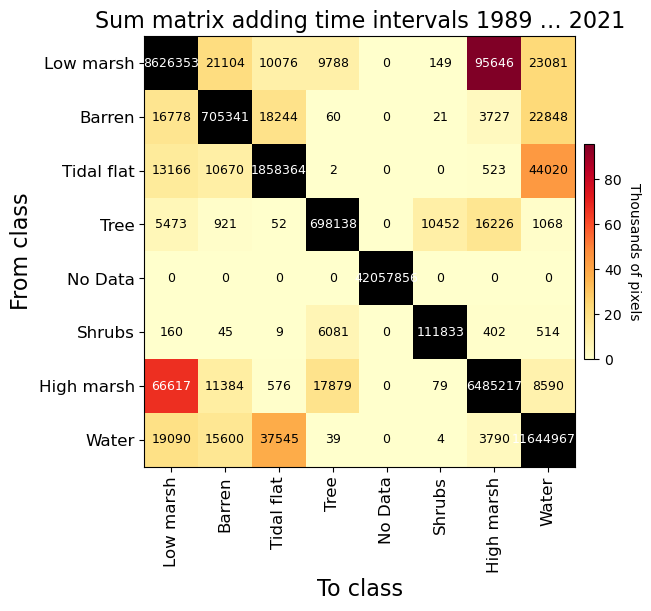

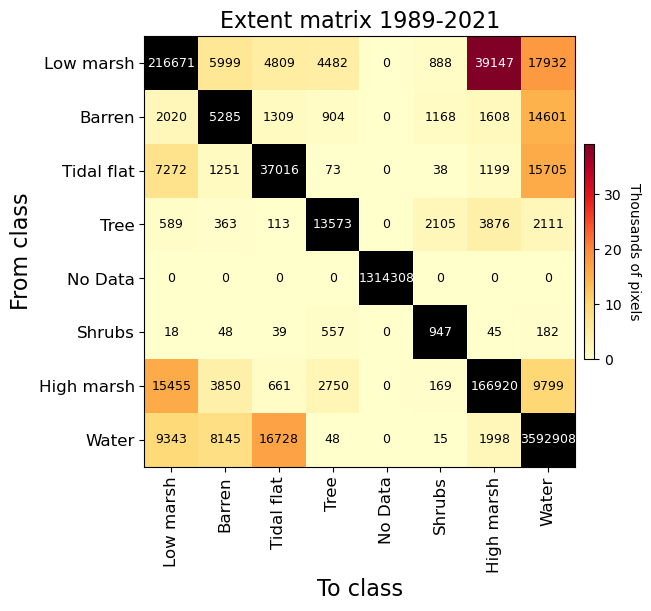

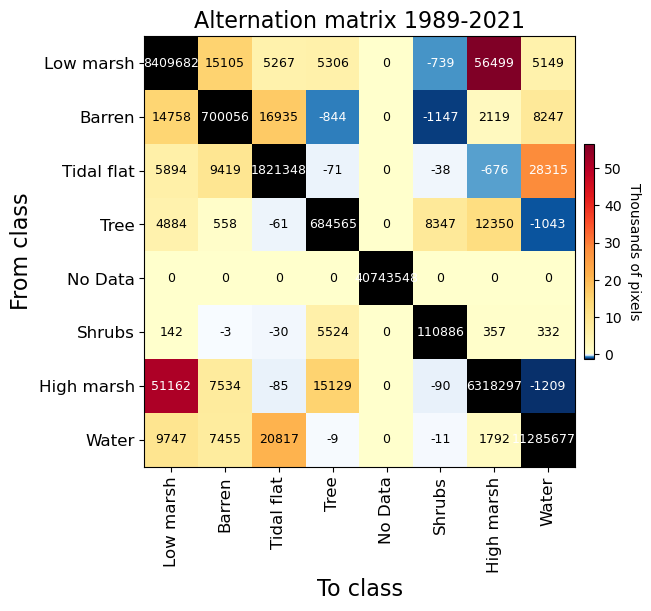

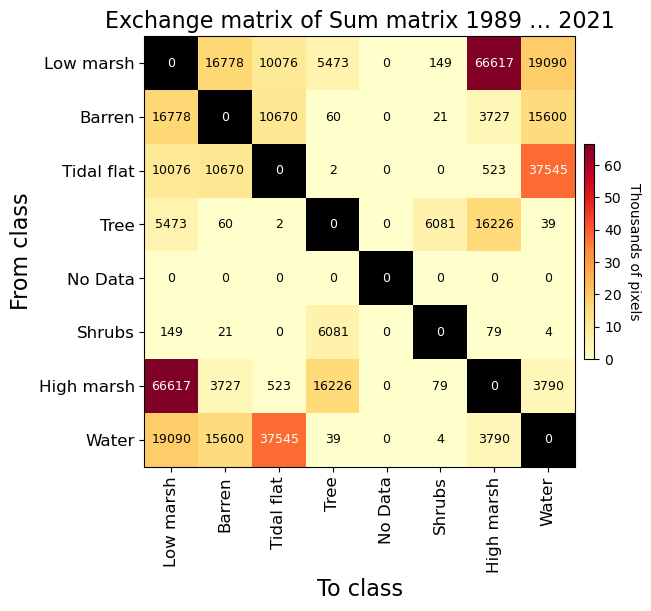

In [16]:
# Paths for output figures
FIG_SUM = OUT_DIR / f"heatmap_SUM_{Y0}-{Y1}.png"
FIG_EXT = OUT_DIR / f"heatmap_EXTENT_{Y0}-{Y1}.png"
FIG_ALT = OUT_DIR / f"heatmap_ALTERNATION_{Y0}-{Y1}.png"
FIG_EXC = OUT_DIR / f"heatmap_EXCHANGE_FROM_SUM_{Y0}-{Y1}.png"

# Plot:
#   - All matrices use the same class order.
#   - Diagonals are drawn in black with white labels.
#   - All colorbars are scaled and labeled in millions of pixels.
for df, title, path in [
    (
        df_sum_plot,
        f"Sum matrix adding time intervals {Y0} … {Y1}",
        FIG_SUM,
    ),
    (
        df_ext_plot,
        f"Extent matrix {Y0}-{Y1}",
        FIG_EXT,
    ),
    (
        df_alt_plot,
        f"Alternation matrix {Y0}-{Y1}",
        FIG_ALT,
    ),
    (
        df_exc_plot,
        f"Exchange matrix of Sum matrix {Y0} … {Y1}",
        FIG_EXC,
    ),
]:
    plot_heatmap(
        df=df,
        title=title,
        save_path=path,
        tick_fontsize=None,
        tick_fontsize_x=12,
        tick_fontsize_y=12,
        axis_label_fontsize=16,
        title_fontsize=16,
        ann_fontsize=9,
        cbar_fraction=0.025,
        cbar_pad=0.02,
    )


## **6.Components of Change**


---
The code calculates components of change from transition matrices generated in the previous step. It features a ComponentCalculator class that processes matrices to determine the gain and loss of Quantity, Exchange, and Shift. The process_matrix function handles matrices for defined time intervals and the main function systematically processes these matrices for each time interval, aggregates the results, and exports the outcomes to a CSV file.

In [17]:
from tqdm import tqdm


# Components from a transition matrix
class ComponentCalculator:
    """
    Compute Quantity, Exchange, and Shift components for each class.

    Parameters
    ----------
    transition_matrix : np.ndarray
        Square transition matrix where rows represent source classes
        and columns represent destination classes. Each cell contains
        the count of pixels transitioning from row class to column class.

    Attributes
    ----------
    matrix : np.ndarray
        Integer transition matrix used for all component calculations.
    num_classes : int
        Number of classes, inferred from the matrix shape.
    class_components : list[dict]
        Per-class dictionaries holding Quantity, Exchange, and Shift
        gains and losses for each class index.
    total_components : dict
        Dictionary storing sums of each component type across all classes.
    """

    def __init__(
        self,
        transition_matrix: np.ndarray,
    ) -> None:
        # Keep integer counts
        self.matrix = transition_matrix.astype(int)
        self.num_classes = transition_matrix.shape[0]
        self.class_components: list[dict] = []
        self.total_components = {
            "Quantity_Gain": 0,
            "Quantity_Loss": 0,
            "Exchange_Gain": 0,
            "Exchange_Loss": 0,
            "Shift_Gain": 0,
            "Shift_Loss": 0,
        }

    def calculate_components(
        self,
    ) -> "ComponentCalculator":
        """
        Compute Quantity, Exchange, and Shift components for each class.

        Returns
        -------
        ComponentCalculator
            Reference to self with the ``class_components`` attribute
            populated for all classes.
        """
        for class_idx in range(self.num_classes):
            gain_sum = np.sum(
                self.matrix[:, class_idx],
            )
            loss_sum = np.sum(
                self.matrix[class_idx, :],
            )

            q_gain = max(
                0,
                gain_sum - loss_sum,
            )
            q_loss = max(
                0,
                loss_sum - gain_sum,
            )

            mutual = np.sum(
                np.minimum(
                    self.matrix[class_idx, :],
                    self.matrix[:, class_idx],
                ),
            )
            exchange = mutual - self.matrix[class_idx, class_idx]

            total_trans = loss_sum - self.matrix[class_idx, class_idx]
            shift = max(
                0,
                total_trans - q_loss - exchange,
            )

            self.class_components.append(
                {
                    "Quantity_Gain": q_gain,
                    "Quantity_Loss": q_loss,
                    "Exchange_Gain": exchange,
                    "Exchange_Loss": exchange,
                    "Shift_Gain": shift,
                    "Shift_Loss": shift,
                },
            )

        return self


def process_matrix(
    matrix_type: str,
    start_year: int | None = None,
    end_year: int | None = None,
) -> list[dict]:
    """
    Load a transition matrix CSV, compute components, and return tidy rows.

    Parameters
    ----------
    matrix_type : str
        Type of matrix to process. Accepted values are:
        ``"interval"``, ``"extent"``, ``"sum"``, or ``"alternation"``.
    start_year : int, optional
        Start year of the interval when ``matrix_type == "interval"``.
        Ignored for other matrix types.
    end_year : int, optional
        End year of the interval when ``matrix_type == "interval"``.
        Ignored for other matrix types.

    Returns
    -------
    list[dict]
        List of records with keys:
        ``"Time_Interval"``, ``"Class"``, ``"Component"``,
        ``"Gain"``, and ``"Loss"``. An empty list is returned if
        the file is missing or an error occurs.
    """
    results: list[dict] = []
    fname: str | None = None

    try:
        # Resolve filename for the requested matrix type
        if matrix_type == "interval":
            fname = f"transition_matrix_{start_year}-{end_year}.csv"
        elif matrix_type == "extent":
            fname = f"transition_matrix_extent_{years[0]}-{years[-1]}.csv"
        elif matrix_type == "sum":
            fname = f"transition_matrix_sum_{years[0]}-{years[-1]}.csv"
        elif matrix_type == "alternation":
            fname = (
                f"transition_matrix_alternation_"
                f"{years[0]}-{years[-1]}.csv"
            )

        # Validate path
        full_path = os.path.join(
            output_path,
            fname,
        )
        if not os.path.exists(full_path):
            raise FileNotFoundError(
                f"File {full_path} does not exist",
            )

        # Read matrix and compute components
        df = pd.read_csv(
            full_path,
            index_col=0,
        )
        matrix_classes = [int(c) for c in df.index]
        calc = ComponentCalculator(
            transition_matrix=df.values,
        ).calculate_components()

        # Build tidy records for each class and component
        for idx, class_id in enumerate(matrix_classes):
            cls_name = class_labels_dict.get(
                class_id,
                {},
            ).get(
                "name",
                f"Unknown_{class_id}",
            )
            comp = calc.class_components[idx]

            for component in [
                "Quantity",
                "Exchange",
                "Shift",
            ]:
                component_name = component
                if (
                    matrix_type in [
                        "extent",
                        "sum",
                    ]
                    and component
                    in [
                        "Exchange",
                        "Shift",
                    ]
                ):
                    component_name = f"Allocation_{component}"

                results.append(
                    {
                        "Time_Interval": (
                            f"{start_year}-{end_year}"
                            if matrix_type == "interval"
                            else matrix_type
                        ),
                        "Class": cls_name,
                        "Component": component_name,
                        "Gain": comp[f"{component}_Gain"],
                        "Loss": comp[f"{component}_Loss"],
                    },
                )

    except Exception as e:
        print(f"ERROR in {matrix_type}: {str(e)}")
        return []

    return results


def main(
    output_path: str,
) -> None:
    """
    Run the component-calculation workflow for all transition matrices.

    Parameters
    ----------
    output_path : str
        Directory where transition-matrix CSVs are stored and where the
        aggregated ``change_components.csv`` will be written.

    Returns
    -------
    None
        Prints basic logging information and writes the final CSV file.
    """
    all_results: list[dict] = []
    print("\nStarting processing")

    # 1) Interval matrices
    try:
        print("\nProcessing intervals...")
        for i in tqdm(
            range(len(years) - 1),
            desc="Interval components",
            unit="interval",
        ):
            start = years[i]
            end = years[i + 1]
            all_results.extend(
                process_matrix(
                    matrix_type="interval",
                    start_year=start,
                    end_year=end,
                ),
            )
    except Exception as e:
        print(f"Fatal error in intervals: {str(e)}")
        return

    # 2) Extent matrix
    try:
        print("\nProcessing extent matrix...")
        for _ in tqdm(
            range(1),
            desc="Extent components",
            unit="matrix",
        ):
            all_results.extend(
                process_matrix(
                    matrix_type="extent",
                    start_year=None,
                    end_year=None,
                ),
            )
    except Exception as e:
        print(f"Fatal error in extent: {str(e)}")
        return

    # 3) Sum matrix
    try:
        print("\nProcessing sum matrix...")
        for _ in tqdm(
            range(1),
            desc="Sum components",
            unit="matrix",
        ):
            all_results.extend(
                process_matrix(
                    matrix_type="sum",
                    start_year=None,
                    end_year=None,
                ),
            )
    except Exception as e:
        print(f"Fatal error in sum: {str(e)}")
        return

    # 4) Alternation matrix
    try:
        print("\nAttempting alternation matrix...")
        alternation_path = os.path.join(
            output_path,
            f"transition_matrix_alternation_{years[0]}-{years[-1]}.csv",
        )

        if os.path.exists(alternation_path):
            df_alt = pd.read_csv(
                alternation_path,
                index_col=0,
            )
            calc = ComponentCalculator(
                transition_matrix=df_alt.values,
            ).calculate_components()

            for idx, class_id in tqdm(
                list(enumerate(df_alt.index.astype(int))),
                desc="Alternation components",
                unit="class",
            ):
                cls_name = class_labels_dict.get(
                    class_id,
                    {},
                ).get(
                    "name",
                    f"Unknown_{class_id}",
                )
                comp = calc.class_components[idx]

                all_results.extend(
                    [
                        {
                            "Time_Interval": "alternation",
                            "Class": cls_name,
                            "Component": "Alternation_Exchange",
                            "Gain": comp["Exchange_Gain"],
                            "Loss": comp["Exchange_Loss"],
                        },
                        {
                            "Time_Interval": "alternation",
                            "Class": cls_name,
                            "Component": "Alternation_Shift",
                            "Gain": comp["Shift_Gain"],
                            "Loss": comp["Shift_Loss"],
                        },
                    ],
                )
        else:
            print("Alternation matrix not found - skipping")
    except Exception as e:
        print(f"Non-fatal alternation error: {str(e)}")

    # 5) Export aggregated components to a single CSV
    try:
        output_file = os.path.join(
            output_path,
            "change_components.csv",
        )
        pd.DataFrame(
            all_results,
        ).to_csv(
            output_file,
            index=False,
        )
        print(f"\nSuccess! Saved to: {output_file}")
        print(f"Total records: {len(all_results):,}")
    except Exception as e:
        print(f"\nFATAL EXPORT ERROR: {str(e)}")



if __name__ == "__main__":
    main(
        output_path=output_path,
    )


Starting processing

Processing intervals...


Interval components: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 651.19interval/s]



Processing extent matrix...


Extent components: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 689.63matrix/s]



Processing sum matrix...


Sum components: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 582.79matrix/s]



Attempting alternation matrix...


Alternation components: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 130561.99class/s]


Success! Saved to: /Users/antoniofonseca/Dataset/vcr/outputs/change_components.csv
Total records: 832


## **6.Graphics**

---



### **6.1 Setting the parameters for the graphics**

In [18]:
# Read change components CSV
csv_path = os.path.join(
    output_path,
    "change_components.csv",
)

# Validate path
if not os.path.exists(csv_path):
    raise FileNotFoundError(
        f"CSV not found: {csv_path}",
    )

print(f"Loaded change components from: {csv_path}")

# Load into DataFrame
df = pd.read_csv(
    csv_path,
)


Loaded change components from: /Users/antoniofonseca/Dataset/vcr/outputs/change_components.csv


### **6.2 Change Components by Time Interval**

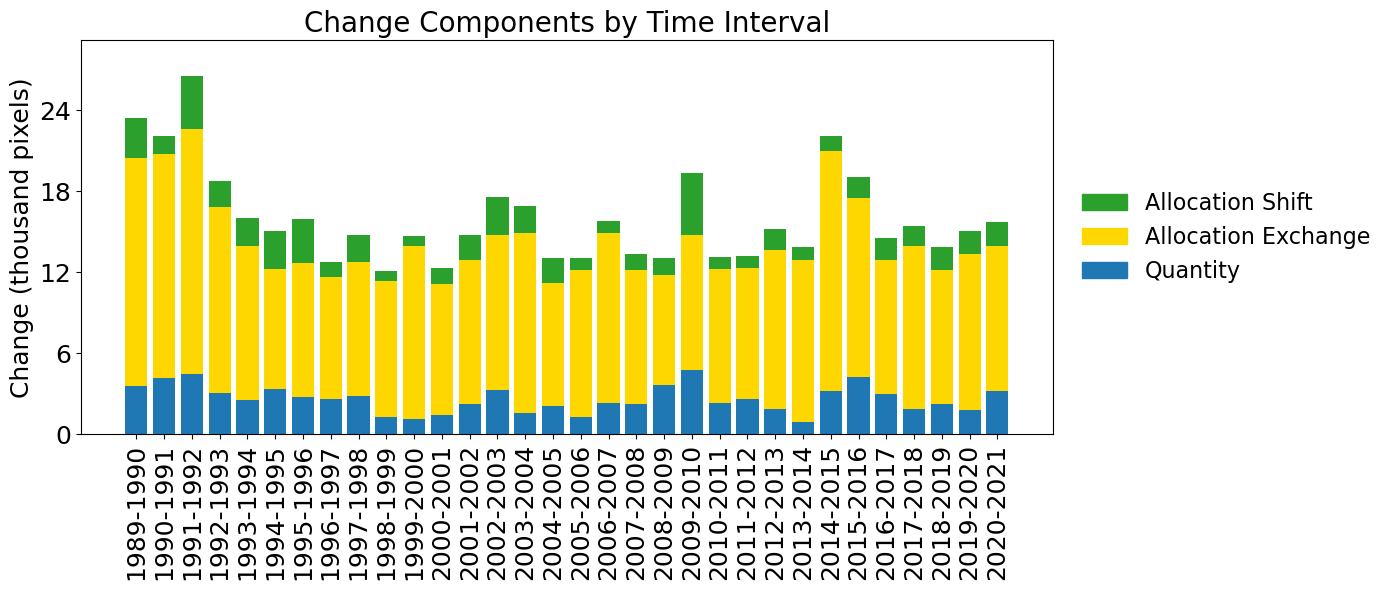

In [20]:
# Filter only time intervals
time_df = df[
    df["Time_Interval"].str.contains("-")
]

# Aggregate totals per interval and component (Gain)
totals = (
    time_df.groupby(
        ["Time_Interval", "Component"],
    )["Gain"]
    .sum()
    .unstack()
)

# Choose scale automatically based on max value
max_val = totals[["Quantity", "Exchange", "Shift"]].to_numpy().max()

if max_val >= 1_000_000:
    scale_factor = 1_000_000
    y_label = "Change (million pixels)"
elif max_val >= 1_000:
    scale_factor = 1_000
    y_label = "Change (thousand pixels)"
elif max_val >= 100:
    scale_factor = 100
    y_label = "Change (hundred pixels)"
else:
    scale_factor = 1
    y_label = "Change (pixels)"

# Scaled totals per component for plotting
scaled_totals = totals[
    [
        "Quantity",
        "Exchange",
        "Shift",
    ]
] / scale_factor

# Maximum stacked height (Quantity + Exchange + Shift)
stacked_max = scaled_totals.sum(
    axis=1,
).max()

# Create figure and axis
fig, ax = plt.subplots(
    figsize=(
        14,
        6,
    ),
)

# Colors
colors = [
    "#1f77b4",  # Quantity
    "#ffd700",  # Exchange
    "#2ca02c",  # Shift
]
components_color = {
    "Quantity": "#1f77b4",
    "Exchange": "#ffd700",
    "Shift": "#2ca02c",
}

# Stacked bars (Quantity, Exchange, Shift) using scaled values
for idx, comp in enumerate(
    [
        "Quantity",
        "Exchange",
        "Shift",
    ],
):
    bottom_values = (
        scaled_totals.iloc[:, :idx].sum(
            axis=1,
        )
        if idx > 0
        else 0
    )
    ax.bar(
        totals.index,
        scaled_totals[comp],
        label=comp,
        color=colors[idx],
        edgecolor="none",
        bottom=bottom_values,
    )

# Axes formatting
ax.set_ylabel(
    y_label,
    fontsize=18,
)
ax.set_title(
    "Change Components by Time Interval",
    fontsize=20,
)
ax.tick_params(
    axis="both",
    which="major",
    labelsize=18,
)

# Adaptive rotation for x-axis tick labels
labels = ax.get_xticklabels()
n_labels = len(labels)

if n_labels <= 6:
    rotation = 0
    ha = "center"
elif n_labels <= 12:
    rotation = 45
    ha = "right"
else:
    rotation = 90
    ha = "center"

plt.setp(
    labels,
    rotation=rotation,
    ha=ha,
)

# Y-axis limits and ticks based on stacked maximum
y_max_scaled = stacked_max * 1.1
ax.set_ylim(
    0,
    y_max_scaled,
)
ax.yaxis.set_major_locator(
    ticker.MaxNLocator(
        nbins=5,
        integer=True,

    ),
)
ax.yaxis.set_major_formatter(
    ticker.FormatStrFormatter(
        "%d",
    ),
)

# Legend (custom labels)
legend_elements = [
    plt.Rectangle(
        (0, 0),
        1,
        1,
        color=components_color["Shift"],
        label="Allocation Shift",
    ),
    plt.Rectangle(
        (0, 0),
        1,
        1,
        color=components_color["Exchange"],
        label="Allocation Exchange",
    ),
    plt.Rectangle(
        (0, 0),
        1,
        1,
        color=components_color["Quantity"],
        label="Quantity",
    ),
]
ax.legend(
    handles=legend_elements,
    loc="center left",
    bbox_to_anchor=(
        1.01,
        0.5,
    ),
    fontsize=16,
    frameon=False,
)

# Save and show
plt.tight_layout()
plt.savefig(
    os.path.join(
        output_path,
        "graphic_change_components_time_interval.jpeg",
    ),
    bbox_inches="tight",
    format="jpeg",
    dpi=300,
)
plt.show()


### **6.3 Change Components Overall**

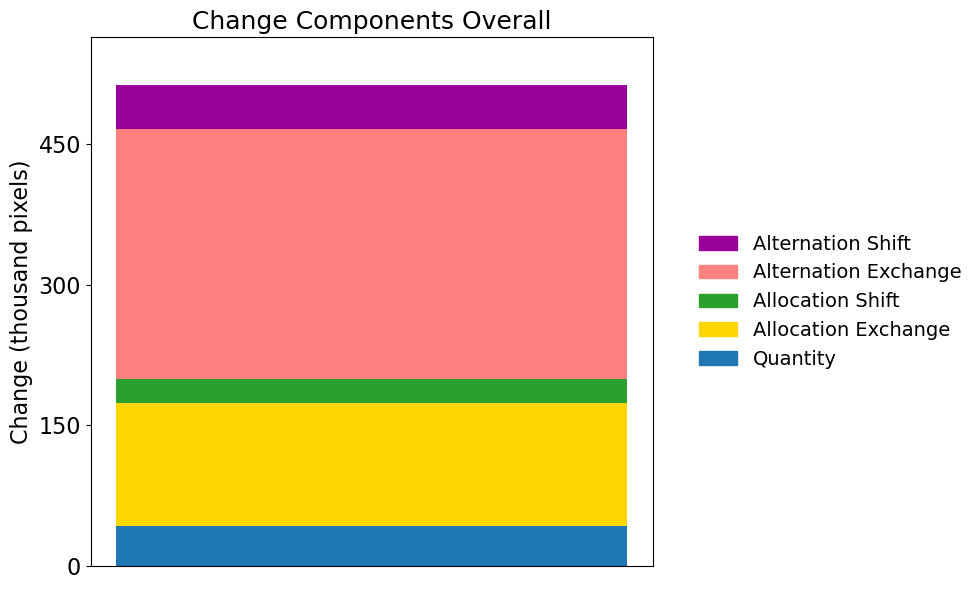

In [21]:
def plot_components_with_alternation(
    csv_path: str,
    output_path: str,
) -> None:
    """
    Plot overall change components as a single stacked bar with auto-scaled y-axis.

    Parameters
    ----------
    csv_path : str
        Path to the CSV file containing change components
        (output of the transition-matrix workflow).
    output_path : str
        Directory where the output figure
        ``graphic_change_components_overall.jpeg`` will be saved.

    Notes
    -----
    The function aggregates:
    - Quantity and Allocation components from the extent matrix.
    - Alternation components from the alternation matrix.

    The y-axis scale (pixels, hundred, thousand, or million pixels)
    is chosen automatically based on the maximum component total.
    """

    # Load data
    df = pd.read_csv(
        csv_path,
    )

    # Colors and component order
    components_color = {
        "Quantity": "#1f77b4",
        "Allocation_Exchange": "#ffd700",
        "Alternation_Exchange": "#ff8080",
        "Allocation_Shift": "#2ca02c",
        "Alternation_Shift": "#990099",
    }
    component_order = [
        "Quantity",
        "Allocation_Exchange",
        "Allocation_Shift",
        "Alternation_Exchange",
        "Alternation_Shift",
    ]

    # Totals per component (extent + alternation)
    component_totals = {
        "Quantity": df[
            (df["Component"] == "Quantity")
            & (df["Time_Interval"] == "extent")
        ]["Gain"].sum(),
        "Allocation_Exchange": df[
            (df["Component"] == "Allocation_Exchange")
            & (df["Time_Interval"] == "extent")
        ]["Gain"].sum(),
        "Allocation_Shift": df[
            (df["Component"] == "Allocation_Shift")
            & (df["Time_Interval"] == "extent")
        ]["Gain"].sum(),
        "Alternation_Exchange": df[
            df["Component"] == "Alternation_Exchange"
        ]["Gain"].sum(),
        "Alternation_Shift": df[
            df["Component"] == "Alternation_Shift"
        ]["Gain"].sum(),
    }

    # Automatic scale based on maximum total
    max_val = max(component_totals.values())

    if max_val >= 1_000_000:
        scale_factor = 1_000_000
        y_label = "Change (million pixels)"
    elif max_val >= 1_000:
        scale_factor = 1_000
        y_label = "Change (thousand pixels)"
    elif max_val >= 100:
        scale_factor = 100
        y_label = "Change (hundred pixels)"
    else:
        scale_factor = 1
        y_label = "Change (pixels)"

    # Figure
    fig, ax = plt.subplots(
        figsize=(
            10,
            6,
        ),
    )

    # Stacked bar (single x=0) using scaled values
    bottom = 0.0
    for component in component_order:
        value = component_totals.get(
            component,
            0.0,
        ) / scale_factor
        ax.bar(
            x=0,
            height=value,
            bottom=bottom,
            color=components_color[component],
            edgecolor="none",
            width=0.8,
        )
        bottom += value

    # Axes formatting
    ax.set_ylabel(
        y_label,
        fontsize=16,
    )
    ax.set_title(
        "Change Components Overall",
        fontsize=18,
    )
    ax.xaxis.set_visible(False)
    ax.tick_params(
        axis="both",
        which="major",
        labelsize=16,
    )

    # Y-axis limits and ticks based on stacked maximum
    y_max_scaled = bottom * 1.1 if bottom > 0 else 1.0
    ax.set_ylim(
        0,
        y_max_scaled,
    )
    ax.yaxis.set_major_locator(
        ticker.MaxNLocator(
            nbins=5,
            integer=True,
        ),
    )
    ax.yaxis.set_major_formatter(
        ticker.FormatStrFormatter(
        "%d",
        ),
    )

    # Borders
    for spine in [
        "top",
        "right",
        "left",
        "bottom",
    ]:
        ax.spines[spine].set_visible(True)

    # Legend (custom labels)
    legend_elements = [
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Alternation_Shift"],
            label="Alternation Shift",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Alternation_Exchange"],
            label="Alternation Exchange",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Allocation_Shift"],
            label="Allocation Shift",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Allocation_Exchange"],
            label="Allocation Exchange",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Quantity"],
            label="Quantity",
        ),
    ]
    ax.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(
            1.05,
            0.5,
        ),
        fontsize=14,
        frameon=False,
    )

    # Save
    plt.tight_layout()
    plt.savefig(
        os.path.join(
            output_path,
            "graphic_change_components_overall.jpeg",
        ),
        bbox_inches="tight",
        format="jpeg",
        dpi=300,
    )
    plt.show()

if __name__ == "__main__":
    csv_file = os.path.join(
        output_path,
        "change_components.csv",
    )
    plot_components_with_alternation(
        csv_file,
        output_path,
    )


### **6.4 Change Componentes by Class**

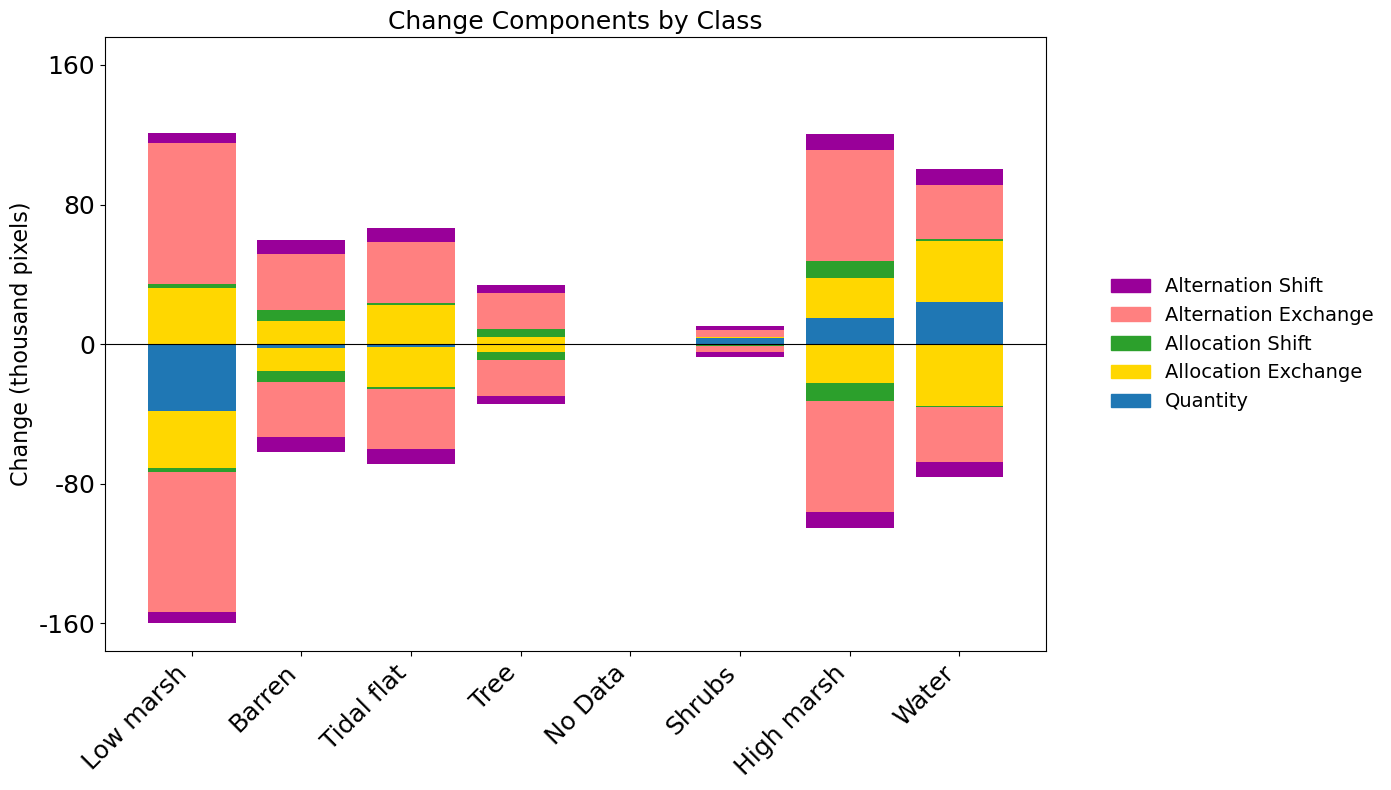

In [22]:
class ComponentVisualizer:
    """Visualize change components by class, including alternation."""

    @staticmethod
    def plot_gain_loss_stacked(
        class_labels_dict: dict,
        title: str,
        output_path: str,
    ) -> None:
        """
        Plot per-class gains and losses as stacked bars with auto-scaled y-axis.

        Parameters
        ----------
        class_labels_dict : dict
            Mapping from class ID to metadata with at least a ``"name"`` key.
        title : str
            Title for the figure.
        output_path : str
            Directory where the output figure
            ``graphic_change_component_change_class.jpeg`` will be saved.

        Notes
        -----
        Uses rows where ``Time_Interval`` is ``"extent"`` or ``"alternation"``.
        Gains are stacked upwards, losses downwards (negative),
        for components Quantity, Allocation Exchange/Shift,
        and Alternation Exchange/Shift.
        """

        global df  # uses the global DataFrame generated earlier

        # Filter data to extent and alternation
        filtered_df = df[
            df["Time_Interval"].isin(
                [
                    "extent",
                    "alternation",
                ],
            )
        ]

        # Existing classes (exclude id 0 if present)
        existing_classes = [
            cls
            for cls in filtered_df["Class"].unique()
            if cls != noData_value
        ]

        # Colors and component order
        components_color = {
            "Quantity": "#1f77b4",
            "Allocation_Exchange": "#ffd700",
            "Alternation_Exchange": "#ff8080",
            "Allocation_Shift": "#2ca02c",
            "Alternation_Shift": "#990099",
        }
        component_order = [
            "Quantity",
            "Allocation_Exchange",
            "Allocation_Shift",
            "Alternation_Exchange",
            "Alternation_Shift",
        ]

        # Sort classes by net quantity (gain - loss)
        class_totals: list[tuple[str, float]] = []
        for cls in existing_classes:
            class_data = filtered_df[
                filtered_df["Class"] == cls
            ]
            quantity_gain = class_data[
                class_data["Component"] == "Quantity"
            ]["Gain"].sum()
            quantity_loss = class_data[
                class_data["Component"] == "Quantity"
            ]["Loss"].sum()
            class_totals.append(
                (
                    cls,
                    quantity_gain - quantity_loss,
                ),
            )

        sorted_classes = sorted(
            class_totals,
            key=lambda x: x[1],
        )
        ordered_classes = [
            cls
            for cls, _ in sorted_classes
        ]

        # Compute maximum absolute stacked height per class
        max_abs_val = 0.0
        for cls in ordered_classes:
            class_data = filtered_df[
                filtered_df["Class"] == cls
            ]
            gains_total = 0.0
            losses_total = 0.0

            for comp in component_order:
                gains_total += class_data[
                    class_data["Component"] == comp
                ]["Gain"].sum()
                losses_total += class_data[
                    class_data["Component"] == comp
                ]["Loss"].sum()

            max_abs_val = max(
                max_abs_val,
                abs(gains_total),
                abs(losses_total),
            )

        # Automatic scale based on maximum absolute value
        if max_abs_val >= 1_000_000:
            scale_factor = 1_000_000
            y_label = "Change (million pixels)"
        elif max_abs_val >= 1_000:
            scale_factor = 1_000
            y_label = "Change (thousand pixels)"
        elif max_abs_val >= 100:
            scale_factor = 100
            y_label = "Change (hundred pixels)"
        else:
            scale_factor = 1
            y_label = "Change (pixels)"

        # Figure
        fig, ax = plt.subplots(
            figsize=(
                14,
                8,
            ),
        )
        fig.subplots_adjust(
            left=0.1,
            right=0.75,
        )

        x_positions = np.arange(
            len(ordered_classes),
        )
        width = 0.8

        # Stacked bars per class (gains positive, losses negative), scaled
        for idx, cls in enumerate(ordered_classes):
            class_data = filtered_df[
                filtered_df["Class"] == cls
            ]
            gain_bottom = 0.0
            loss_bottom = 0.0

            for comp in component_order:
                # Gains
                gains = (
                    class_data[
                        class_data["Component"] == comp
                    ]["Gain"].sum()
                    / scale_factor
                )
                ax.bar(
                    x_positions[idx],
                    gains,
                    width,
                    bottom=gain_bottom,
                    color=components_color[comp],
                    edgecolor="none",
                )
                gain_bottom += gains

                # Losses (negative)
                losses = -(
                    class_data[
                        class_data["Component"] == comp
                    ]["Loss"].sum()
                    / scale_factor
                )
                ax.bar(
                    x_positions[idx],
                    losses,
                    width,
                    bottom=loss_bottom,
                    color=components_color[comp],
                    edgecolor="none",
                )
                loss_bottom += losses

        # Axes formatting
        class_names = [
            class_labels_dict.get(
                cls,
                {},
            ).get(
                "name",
                f"{cls}",
            )
            for cls in ordered_classes
        ]
        ax.set_xticks(
            x_positions,
        )
        ax.set_xticklabels(
            class_names,
            rotation=45,
            ha="right",
            fontsize=18,
        )
        ax.axhline(
            0,
            color="black",
            linewidth=0.8,
        )
        ax.set_ylabel(
            y_label,
            fontsize=16,
        )
        ax.set_title(
            title,
            fontsize=18,
        )
        ax.tick_params(
            axis="both",
            which="major",
            labelsize=18,
        )

        # Y-axis limits and ticks based on scaled maximum
        y_max_scaled = max_abs_val / scale_factor * 1.1 if max_abs_val > 0 else 1.0
        ax.set_ylim(
            -y_max_scaled,
            y_max_scaled,
        )
        ax.yaxis.set_major_locator(
        ticker.MaxNLocator(
        nbins=5,
        integer=True,
        ),
        )
        ax.yaxis.set_major_formatter(
        ticker.FormatStrFormatter(
        "%d",
        ),
        )

        # Legend
        legend_elements = [
            plt.Rectangle(
                (0, 0),
                1,
                1,
                color=components_color["Alternation_Shift"],
                label="Alternation Shift",
            ),
            plt.Rectangle(
                (0, 0),
                1,
                1,
                color=components_color["Alternation_Exchange"],
                label="Alternation Exchange",
            ),
            plt.Rectangle(
                (0, 0),
                1,
                1,
                color=components_color["Allocation_Shift"],
                label="Allocation Shift",
            ),
            plt.Rectangle(
                (0, 0),
                1,
                1,
                color=components_color["Allocation_Exchange"],
                label="Allocation Exchange",
            ),
            plt.Rectangle(
                (0, 0),
                1,
                1,
                color=components_color["Quantity"],
                label="Quantity",
            ),
        ]
        ax.legend(
            handles=legend_elements,
            loc="center left",
            bbox_to_anchor=(
                1.05,
                0.5,
            ),
            fontsize=14,
            frameon=False,
        )

        # Save and show
        plt.tight_layout()
        plt.savefig(
            os.path.join(
                output_path,
                "graphic_change_component_change_class.jpeg",
            ),
            format="jpeg",
            dpi=300,
            bbox_inches="tight",
        )
        plt.show()


# Call
ComponentVisualizer.plot_gain_loss_stacked(
    class_labels_dict=class_labels_dict,
    title="Change Components by Class",
    output_path=output_path,
)


## **7. Number of Changes**

### 7.1 Compute Number of Changes

In [23]:
from tqdm import tqdm

# Parameters
CHUNK_SIZE = 512          # rows per chunk
BLOCK_SIZE = 256          # tiled block size

# Usa o nodata_value definido anteriormente (por exemplo, 255)
NODATA = noData_value

# Output path
output_raster_path = os.path.join(
    output_path,
    "number_of_changes.tif",
)

print("Starting memory-efficient calculation of number of changes...")

# Template metadata from first masked raster
with rasterio.open(masked_image_paths[0]) as src:
    meta = src.meta.copy()
    height, width = src.shape

# Update output metadata for tiled GeoTIFF
meta.update(
    {
        "dtype": "uint8",
        "count": 1,
        "compress": "lzw",
        "tiled": True,
        "blockxsize": BLOCK_SIZE,
        "blockysize": BLOCK_SIZE,
    },
)

# Create output raster and process in chunks
with rasterio.open(
    output_raster_path,
    "w",
    **meta,
) as dst:
    print(f"Output raster will be written to: {output_raster_path}")

    # Number of vertical chunks
    n_chunks = (height + CHUNK_SIZE - 1) // CHUNK_SIZE

    # Iterate over chunks with progress bar
    for y_start in tqdm(
        range(0, height, CHUNK_SIZE),
        total=n_chunks,
        desc="Change count processing",
        unit="step",
    ):
        y_end = min(
            y_start + CHUNK_SIZE,
            height,
        )
        chunk_h = y_end - y_start
        window = rasterio.windows.Window(
            0,
            y_start,
            width,
            chunk_h,
        )

        # Read current block from each year into a stack
        chunk_stack = np.zeros(
            (
                len(masked_image_paths),
                chunk_h,
                width,
            ),
            dtype=np.uint8,
        )
        for i, path in enumerate(masked_image_paths):
            with rasterio.open(path) as src:
                chunk_stack[i] = src.read(
                    1,
                    window=window,
                )

        # Vectorized change count between consecutive rasters
        # Ignore transitions when previous state is background (0)
        transitions = (
            (chunk_stack[1:] != chunk_stack[:-1])
            & (chunk_stack[:-1] != 0)
        )
        number_of_changes_chunk = np.sum(
            transitions,
            axis=0,
            dtype=np.uint8,
        )

        # Combined background mask (background in all dates)
        background_mask = np.all(
            chunk_stack == 0,
            axis=0,
        )
        number_of_changes_chunk[background_mask] = NODATA

        # Write block to output raster
        dst.write(
            number_of_changes_chunk,
            1,
            window=window,
        )

print(f"Calculation complete. Raster saved to: {output_raster_path}")

Starting memory-efficient calculation of number of changes...
Output raster will be written to: /Users/antoniofonseca/Dataset/vcr/outputs/number_of_changes.tif


Change count processing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 17.51step/s]

Calculation complete. Raster saved to: /Users/antoniofonseca/Dataset/vcr/outputs/number_of_changes.tif


### 7.2 Plot Number of Changes Map

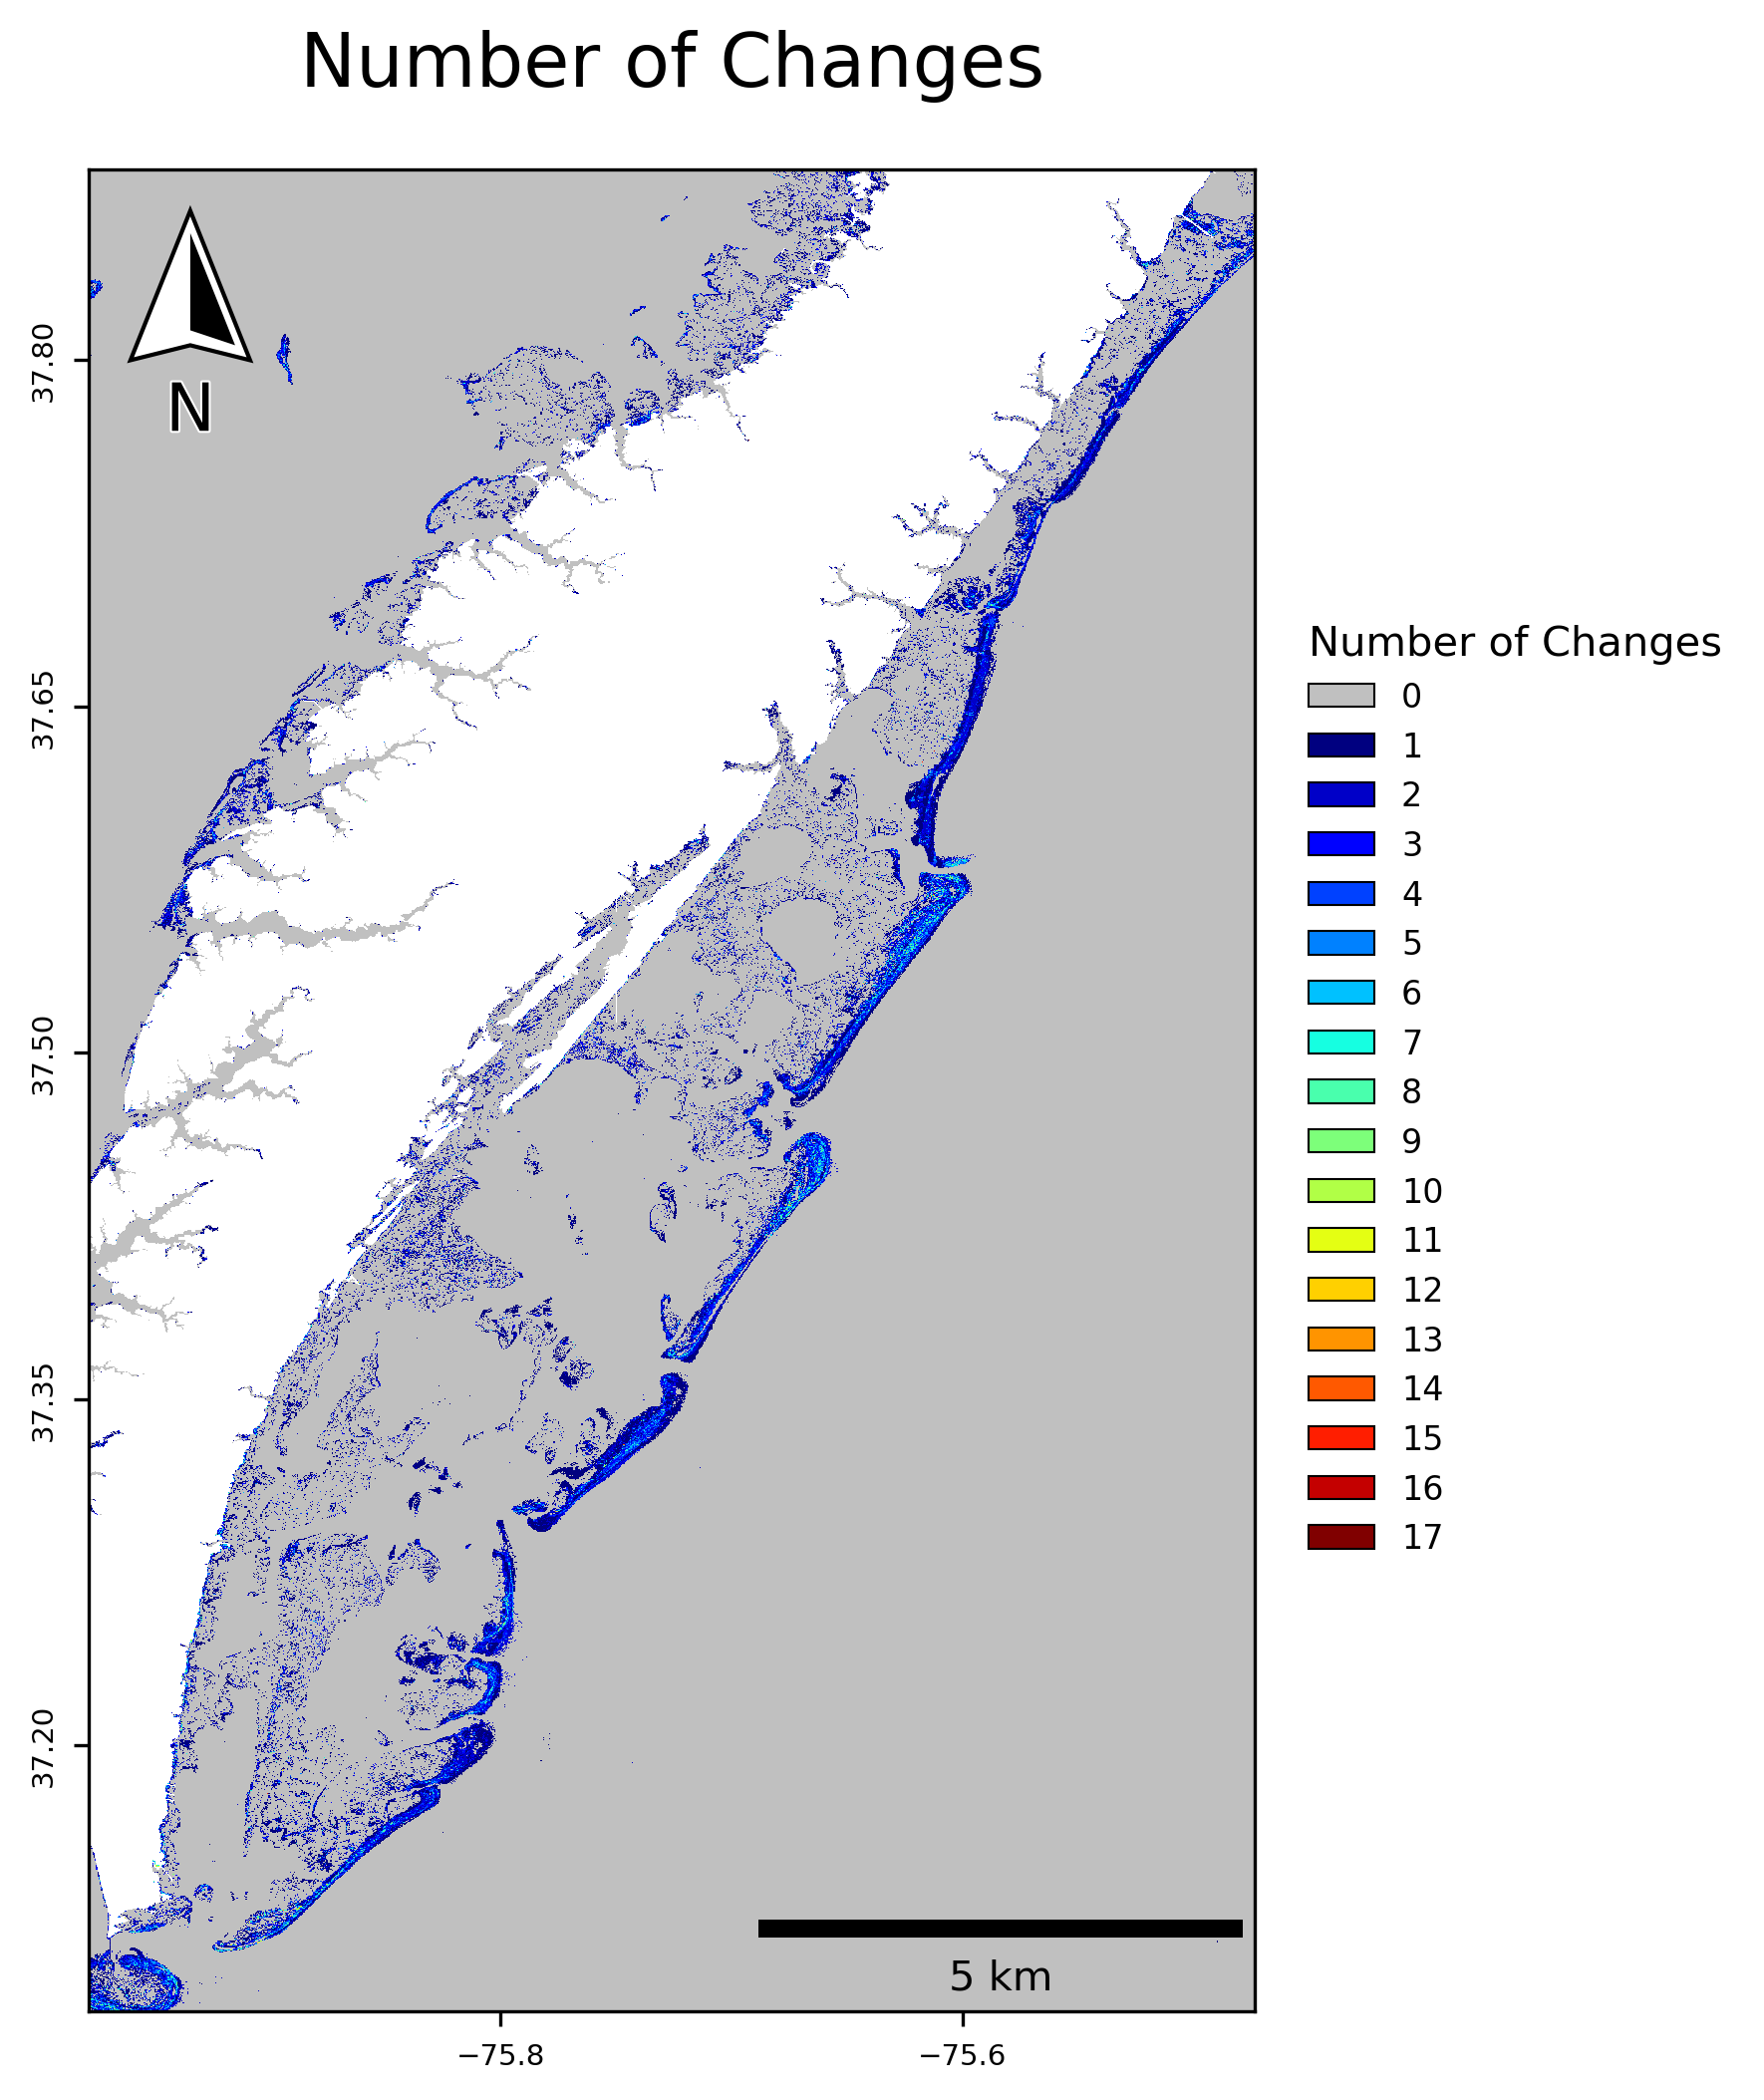

Map figure saved successfully to: /Users/antoniofonseca/Dataset/vcr/outputs/map_number_of_changes.png


In [24]:
# 1) Input raster path
raster_to_plot_path = os.path.join(
    output_path,
    "number_of_changes.tif",
)

# 2) Read raster and basic metadata
with rasterio.open(raster_to_plot_path) as src:
    scale_factor = 1

    data = src.read(
        1,
        out_shape=(
            int(src.height * scale_factor),
            int(src.width * scale_factor),
        ),
        resampling=rasterio.enums.Resampling.nearest,
    )

    nodata_value = src.nodata
    if nodata_value is not None:
        data = np.ma.masked_equal(
            data,
            nodata_value,
        )

    left, bottom, right, top = src.bounds
    src_crs = src.crs
    transform = src.transform

# 3) Figure
fig, ax = plt.subplots(
    figsize=(
        6,
        8,
    ),
    dpi=300,
)

# Data range
min_val = int(
    np.ma.min(data),
)
max_val = int(
    np.ma.max(data),
)

# 4) Colormap (gray for 0 + jet for 1..max)
original_cmap = plt.get_cmap(
    "jet",
)
color_list = [
    "#c0c0c0",
] + [
    original_cmap(i)
    for i in np.linspace(
        0,
        1,
        max_val,
    )
]
cmap = ListedColormap(
    color_list,
)

# Discrete normalization
bounds = np.arange(
    min_val,
    max_val + 2,
) - 0.5
norm = BoundaryNorm(
    bounds,
    cmap.N,
)

# 5) Plot raster in original projection coordinates
ax.imshow(
    data,
    extent=[
        left,
        right,
        bottom,
        top,
    ],
    cmap=cmap,
    interpolation="none",
    norm=norm,
)

# 6) Discrete box legend
legend_elements = []
for i in range(
    min_val,
    max_val + 1,
):
    legend_elements.append(
        Patch(
            facecolor=cmap(
                norm(i),
            ),
            edgecolor="black",
            linewidth=0.5,
            label=str(i),
        ),
    )

ax.legend(
    handles=legend_elements,
    title="Number of Changes",
    loc="center left",
    bbox_to_anchor=(
        1.02,
        0.5,
    ),
    frameon=False,
    fontsize=8,
    title_fontsize=10,
    alignment="left",
)

# 7) Cartographic elements (scale bar + north arrow)

# Compute approximate pixel size in meters for any CRS
if src_crs is not None and src_crs.is_projected:
    pixel_size_m = transform.a
else:
    from pyproj import Geod, CRS

    geod = Geod(
        ellps="WGS84",
    )
    crs_ll = CRS.from_epsg(
        4326,
    )

    if src_crs is not None and src_crs.to_string() != crs_ll.to_string():
        transformer_ll = Transformer.from_crs(
            src_crs,
            crs_ll,
            always_xy=True,
        )
    else:
        transformer_ll = None

    x_center = (left + right) / 2.0
    y_center = (bottom + top) / 2.0

    if transformer_ll is not None:
        lon_center, lat_center = transformer_ll.transform(
            x_center,
            y_center,
        )
        lon_right, _ = transformer_ll.transform(
            x_center + transform.a,
            y_center,
        )
    else:
        lon_center, lat_center = x_center, y_center
        lon_right = x_center + transform.a

    _, _, dist_m = geod.inv(
        lon_center,
        lat_center,
        lon_right,
        lat_center,
    )
    pixel_size_m = dist_m

scalebar = ScaleBar(
    dx=pixel_size_m / 1000.0,
    units="km",
    length_fraction=0.5,
    location="lower right",
    box_alpha=0.0,
    scale_formatter=lambda value, _: f"{int(value)} km",
)
ax.add_artist(
    scalebar,
)

north_arrow(
    ax,
    location="upper left",
    shadow=False,
    rotation={
        "degrees": 0,
    },
)

# 8) Axes styling
ax.set_title(
    "Number of Changes",
    fontsize=18,
    pad=20,
)
ax.set_aspect(
    "equal",
)
ax.tick_params(
    axis="both",
    which="major",
    labelsize=7,
    pad=4,
)
ax.xaxis.set_major_locator(
    plt.MaxNLocator(
        3,
    ),
)
ax.yaxis.set_major_locator(
    plt.MaxNLocator(
        6,
    ),
)

# Show y-axis coordinates on the left, vertically
from matplotlib.ticker import FuncFormatter

ax.yaxis.set_major_formatter(
    FuncFormatter(
        lambda y, pos: f"{y:.2f}",
    ),
)
plt.setp(
    ax.get_yticklabels(),
    rotation=90,
    va="center",
)

# 9) Save
output_figure_path = os.path.join(
    output_path,
    "map_number_of_changes.png",
)
plt.savefig(
    output_figure_path,
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.5,
)
plt.show()

print(
    f"Map figure saved successfully to: {output_figure_path}",
)

## **8. Trajectory Classification**


---
This section provides a framework for processing and classifying pixel trajectories in raster datasets.


### 8.1 Compute Trajectory Analysis
This section processes and visualizes raster data by scaling, applying a color map, and adding graphical elements like legends, scale bars, and north arrows. The output is a high-resolution image of the classified raster data.

In [25]:
# Trajectory classification

@nb.njit(
    nogil=True,
)
def classify_pixel(
    pixel_series,
) -> np.uint8:
    """Classify a single pixel trajectory into four categories."""
    if pixel_series[0] == 0:
        return np.uint8(0)

    start = pixel_series[0]
    end = pixel_series[-1]

    has_variation = False
    direct_transition = False

    # Single pass over the series
    for i in range(
        len(pixel_series) - 1,
    ):
        current = pixel_series[i]
        next_val = pixel_series[i + 1]

        if (not has_variation) and (current != next_val):
            has_variation = True

        if (not direct_transition) and (current == start) and (next_val == end):
            direct_transition = True

    # 1) No change
    if not has_variation:
        return np.uint8(1)
    # 2) Changed but ended where started
    if start == end:
        return np.uint8(2)
    # 3) Direct transition start→end
    if direct_transition:
        return np.uint8(3)
    # 4) Other patterns
    return np.uint8(4)


@nb.njit(
    nogil=True,
    parallel=True,
)
def process_stack_parallel(
    stack,
    height: int,
    width: int,
):
    """Classify all pixels of a stack in parallel."""
    result = np.zeros(
        (
            height,
            width,
        ),
        dtype=np.uint8,
    )
    for y in prange(height):
        for x in range(width):
            result[y, x] = classify_pixel(
                stack[:, y, x],
            )
    return result


class TrajectoryAnalyzer:
    """Chunk-wise trajectory classification for a stack of rasters."""

    @staticmethod
    def process_rasters(
        output_path: str,
        suffix: str = "_masked.tif",
        chunk_size: int = 500,
    ) -> str:
        """
        Process rasters in chunks and write a trajectory classification raster.

        Parameters
        ----------
        output_path : str
            Directory containing input rasters and where ``trajectory.tif``
            will be written.
        suffix : str, optional
            Suffix used to select input rasters in ``output_path``.
        chunk_size : int, optional
            Number of rows per chunk for memory-efficient processing.

        Returns
        -------
        str
            Full path to the output ``trajectory.tif`` file.
        """
        os.makedirs(
            output_path,
            exist_ok=True,
        )
        if not os.path.isdir(output_path):
            raise ValueError(
                f"Path must be a directory: {output_path}",
            )

        raster_files = sorted(
            os.path.join(
                output_path,
                filename,
            )
            for filename in os.listdir(output_path)
            if filename.endswith(suffix)
        )
        if not raster_files:
            raise ValueError(
                f"No files found with suffix '{suffix}' in {output_path}",
            )

        # Read shape and metadata from the first raster
        with rasterio.open(raster_files[0]) as src:
            meta = src.meta.copy()
            height, width = src.shape

        result = np.zeros(
            (
                height,
                width,
            ),
            dtype=np.uint8,
        )

        print(
            f"Starting trajectory processing of {height} rows in chunks of "
            f"{chunk_size}...",
        )

        # Row-wise chunking to limit memory, with progress bar
        n_chunks = (height + chunk_size - 1) // chunk_size
        for y_start in tqdm(
            range(
                0,
                height,
                chunk_size,
            ),
            total=n_chunks,
            desc="Trajectory processing",
            unit="chunk",
        ):
            y_end = min(
                y_start + chunk_size,
                height,
            )
            h_chunk = y_end - y_start

            stack = np.zeros(
                (
                    len(raster_files),
                    h_chunk,
                    width,
                ),
                dtype=np.uint8,
            )
            for i, raster_path in enumerate(raster_files):
                with rasterio.open(raster_path) as src:
                    stack[i] = src.read(
                        1,
                        window=(
                            (
                                y_start,
                                y_end,
                            ),
                            (
                                0,
                                width,
                            ),
                        ),
                    )

            result[
                y_start:y_end,
                :,
            ] = process_stack_parallel(
                stack,
                h_chunk,
                width,
            )

        # Save output
        meta.update(
            {
                "dtype": "uint8",
                "nodata": 0,
                "count": 1,
                "compress": "lzw",
            },
        )
        out_file = os.path.join(
            output_path,
            "trajectory.tif",
        )
        with rasterio.open(
            out_file,
            "w",
            **meta,
        ) as dst:
            dst.write(
                result,
                1,
            )

        print(
            f"Trajectory raster saved to: {out_file}",
        )
        return out_file

print("Starting trajectory analysis...")

trajectory_file = TrajectoryAnalyzer.process_rasters(
    output_path=output_path,
    suffix="_masked.tif",
    chunk_size=500,
)

Starting trajectory analysis...
Starting trajectory processing of 2960 rows in chunks of 500...


Trajectory processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.53chunk/s]

Trajectory raster saved to: /Users/antoniofonseca/Dataset/vcr/outputs/trajectory.tif


### 8.2 Plot Trajectory Analysis Graphic

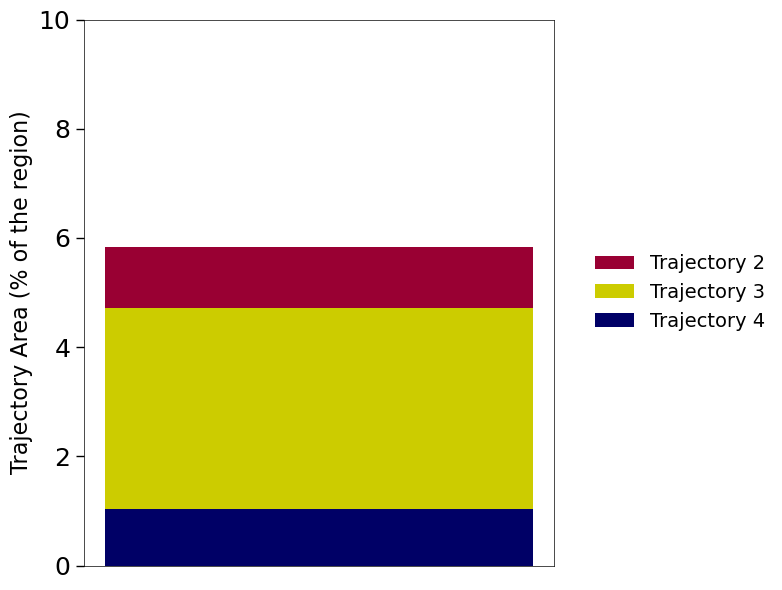

Trajectory distribution figure saved to: /Users/antoniofonseca/Dataset/vcr/outputs/trajectory_distribution.jpeg


In [26]:
def plot_trajectory_distribution(
    output_path: str,
) -> None:
    """
    Plot a stacked bar with the distribution of trajectory classes.

    The function reads the categorical raster ``trajectory.tif`` from
    ``output_path`` (produced by the trajectory analysis step) and
    computes, for each trajectory class, the proportion of valid pixels
    relative to the total valid area.

    The stacked bar aggregates the percentages for classes 2, 3, and 4
    at a single x-position, so the bar height represents the total
    percentage of pixels that experienced any change, while the colored
    segments correspond to:
        - Trajectory 2: pixels that changed but returned to the initial state.
        - Trajectory 3: pixels with direct transition from initial to final
          state.
        - Trajectory 4: pixels with more complex change trajectories.

    The resulting figure is saved as ``trajectory_distribution.jpeg`` in
    the same ``output_path`` directory.
    """
    # Raster path
    raster_path = os.path.join(
        output_path,
        "trajectory.tif",
    )

    # Read raster
    with rasterio.open(
        raster_path,
    ) as src:
        traj_data = src.read(
            1,
        )
        nodata = src.nodata

    # Mask NoData and count classes
    masked_traj = np.ma.masked_where(
        traj_data == nodata,
        traj_data,
    )
    unique, counts = np.unique(
        masked_traj.compressed(),
        return_counts=True,
    )
    total_pixels = counts.sum()

    # Percentages
    percentages = {
        traj_class: (count / total_pixels) * 100.0
        for traj_class, count in zip(
            unique,
            counts,
        )
    }

    # Order and colors
    ordered_trajs = [
        4,
        3,
        2,
    ]
    colors = {
        4: "#000066",
        3: "#cccc00",
        2: "#990033",
    }

    # Y-axis upper bound
    max_percentage = sum(
        percentages.get(
            traj,
            0.0,
        )
        for traj in ordered_trajs
    )
    y_max = np.ceil(
        max_percentage / 10.0,
    ) * 10.0

    # Figure
    fig, ax = plt.subplots(
        figsize=(
            8,
            6,
        ),
    )

    # Stacked bars
    bottom = 0.0
    for traj in ordered_trajs:
        if traj in percentages:
            ax.bar(
                0,
                percentages[traj],
                bottom=bottom,
                color=colors[traj],
                width=0.4,
                edgecolor="none",
            )
            bottom += percentages[traj]

    # Labels
    ax.set_ylabel(
        "Trajectory Area (% of the region)",
        fontsize=16,
    )

    # Frame (all spines visible)
    for spine in [
        "top",
        "right",
        "bottom",
        "left",
    ]:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color("black")
        ax.spines[spine].set_linewidth(0.5)

    # Ticks
    ax.tick_params(
        axis="y",
        which="minor",
        length=0,
    )
    ax.tick_params(
        axis="y",
        which="major",
        labelsize=18,
        length=6,
        width=1,
    )

    # Y scale
    ax.set_ylim(
        0,
        y_max,
    )
    ax.yaxis.set_major_locator(
        ticker.MultipleLocator(
            np.floor(
                y_max / 5.0,
            ),
        ),
    )

    # Hide x-axis
    ax.xaxis.set_visible(False)

    # No grid
    ax.grid(False)

    # Legend
    legend_elements = [
        Patch(
            facecolor=colors[2],
            label="Trajectory 2",
        ),
        Patch(
            facecolor=colors[3],
            label="Trajectory 3",
        ),
        Patch(
            facecolor=colors[4],
            label="Trajectory 4",
        ),
    ]
    ax.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(
            1.05,
            0.5,
        ),
        fontsize=14,
        frameon=False,
    )

    # Save
    output_figure_path = os.path.join(
        output_path,
        "trajectory_distribution.jpeg",
    )
    plt.tight_layout()
    plt.savefig(
        output_figure_path,
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    print(
        f"Trajectory distribution figure saved to: {output_figure_path}",
    )


# Usage
if __name__ == "__main__":
    plot_trajectory_distribution(
        output_path=output_path,
    )

### 8.3 Plot Trajectory Analysis Map

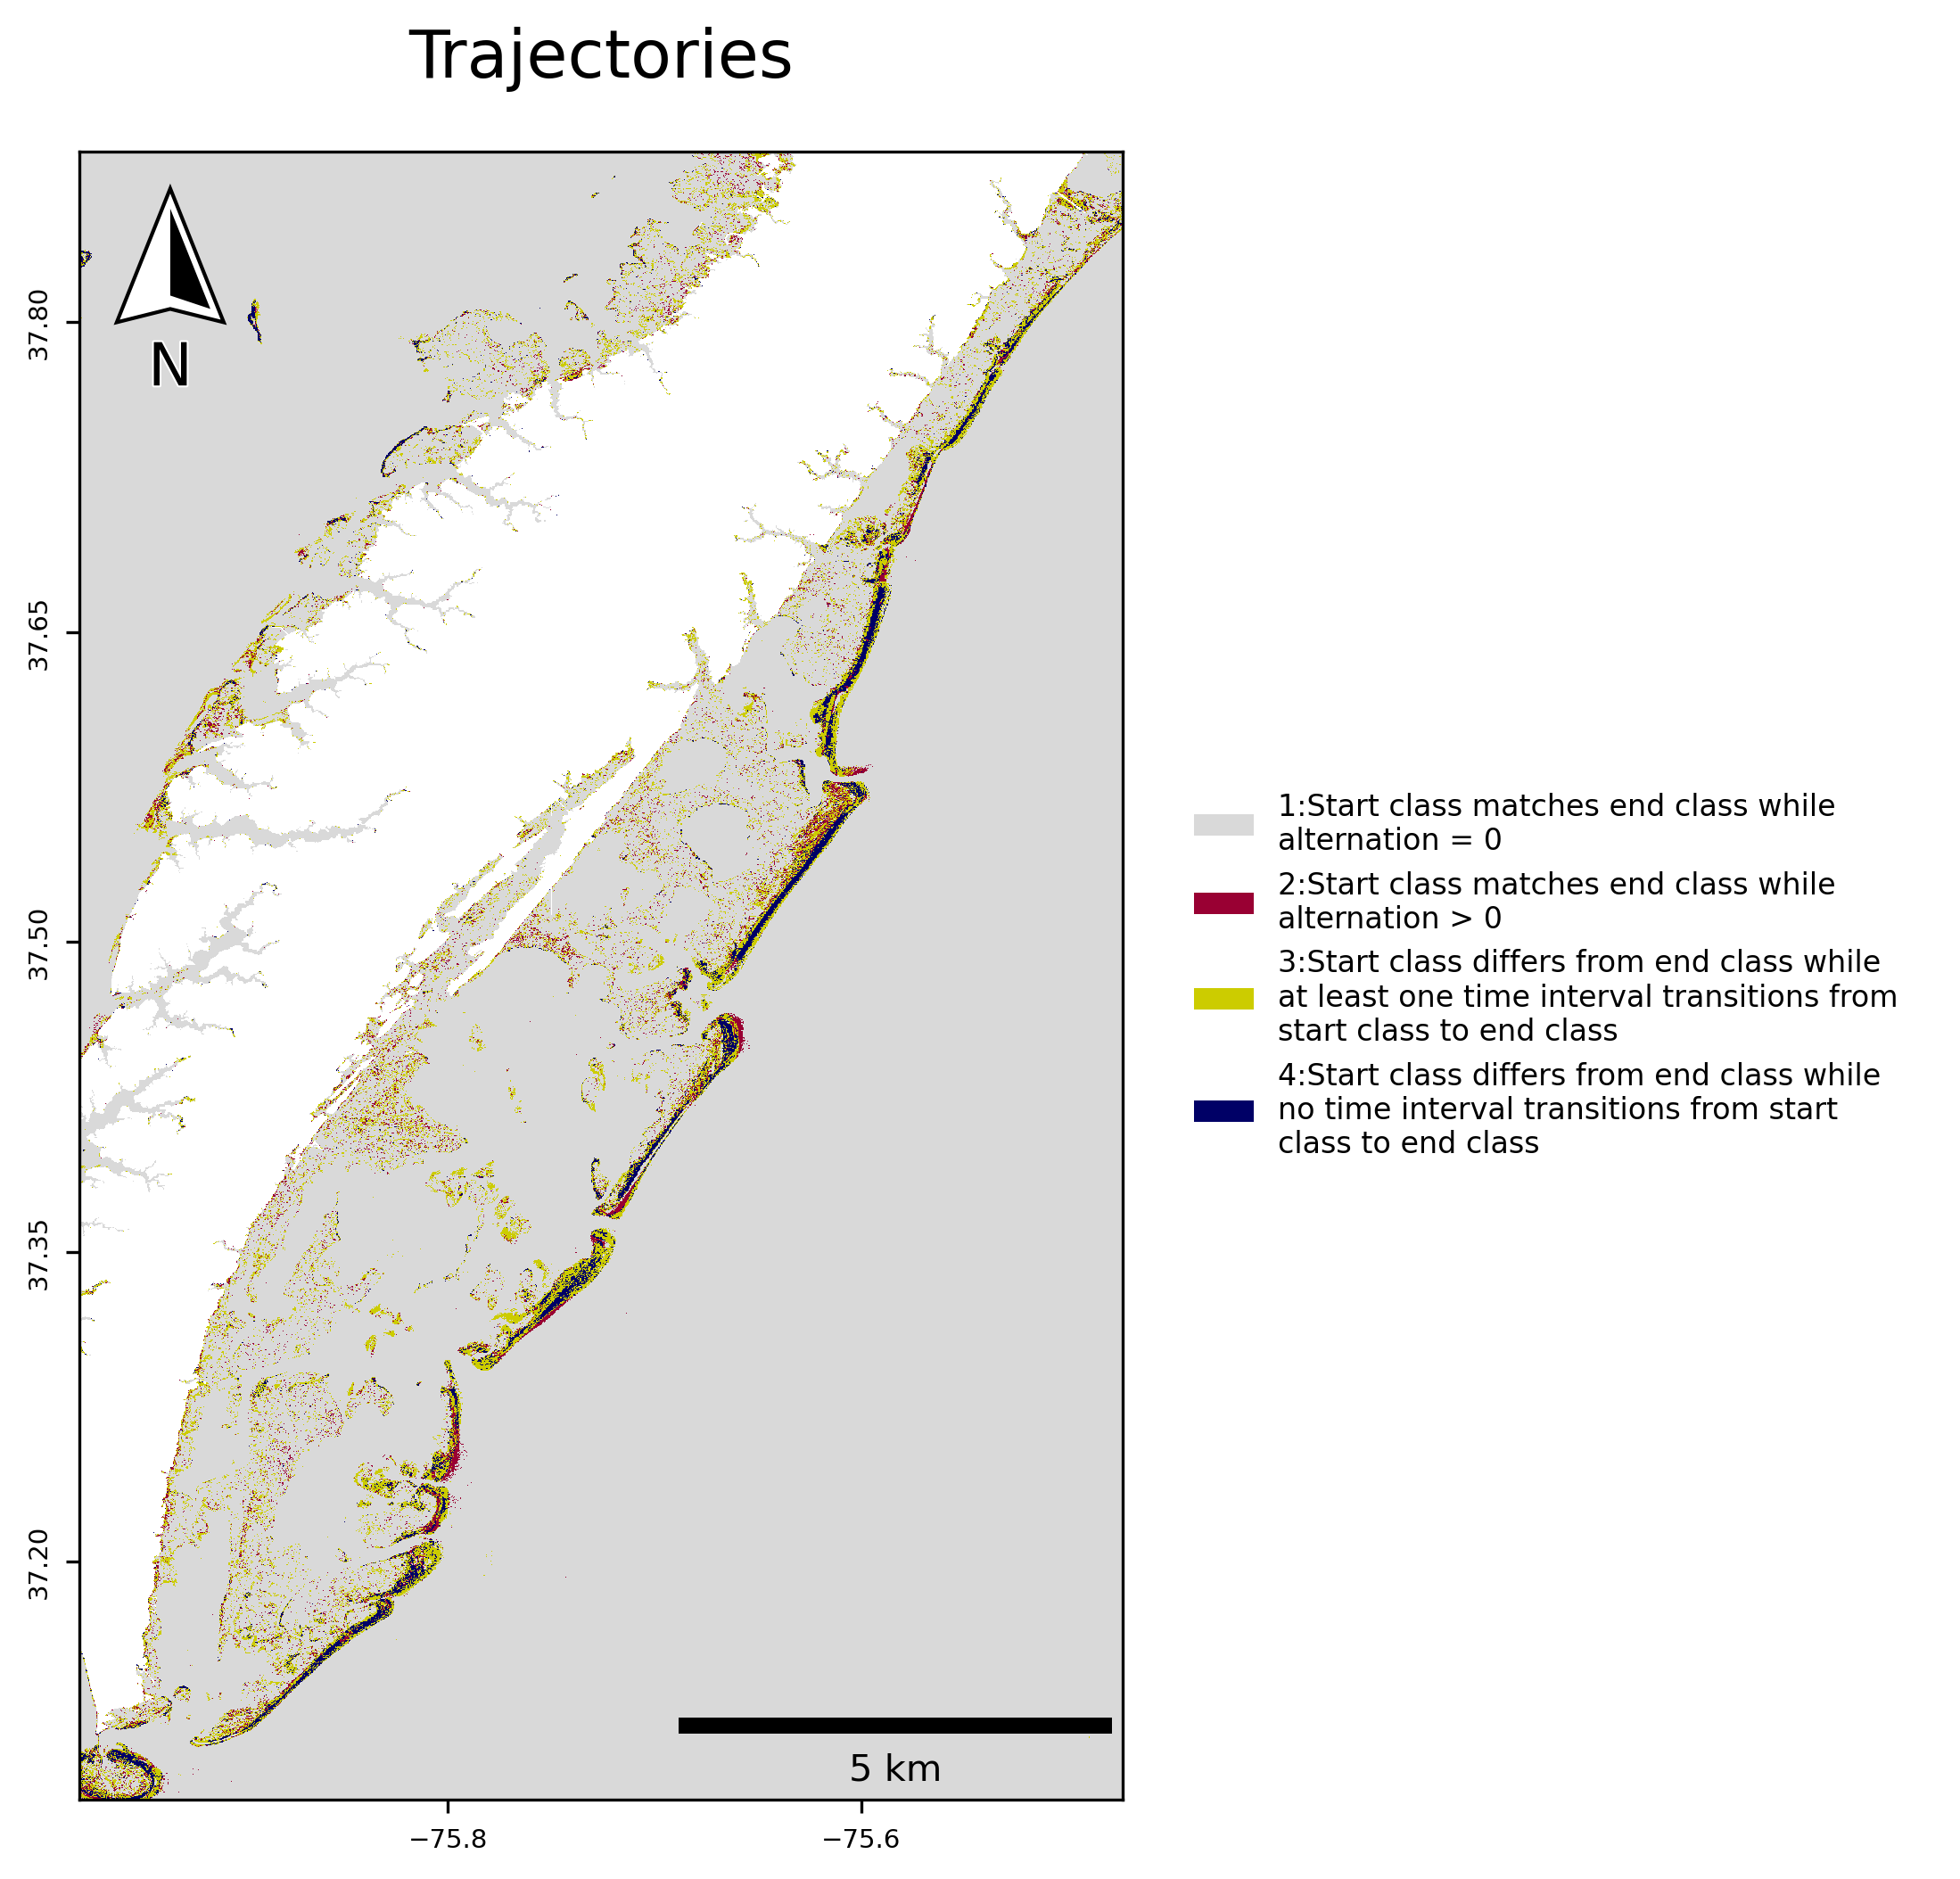

Trajectory map saved successfully to: /Users/antoniofonseca/Dataset/vcr/outputs/map_trajectories.png


In [28]:
# 1) Input raster path
raster_path = os.path.join(
    output_path,
    "trajectory.tif",
)

# 2) Read raster and basic metadata
with rasterio.open(
    raster_path,
) as src:
    scale_factor = 1

    data = src.read(
        1,
        out_shape=(
            int(src.height * scale_factor),
            int(src.width * scale_factor),
        ),
        resampling=rasterio.enums.Resampling.nearest,
    )

    left, bottom, right, top = src.bounds
    src_crs = src.crs
    transform = src.transform

# 3) Figure
fig, ax = plt.subplots(
    figsize=(
        6,
        8,
    ),
    dpi=300,
)

# 4) Colormap (categorical: 0–4)
cmap = ListedColormap(
    [
        "#ffffff",
        "#d9d9d9",
        "#990033",
        "#cccc00",
        "#000066",
    ],
)

# 5) Plot raster in original projection coordinates
ax.imshow(
    data,
    extent=[
        left,
        right,
        bottom,
        top,
    ],
    cmap=cmap,
    interpolation="none",
)

# 6) Legend
legend_elements = [
    Rectangle(
        (0, 0),
        1,
        1,
        facecolor="#d9d9d9",
        label=(
            "1:Start class matches end class while\n"
            "alternation = 0"
        ),
    ),
    Rectangle(
        (0, 0),
        1,
        1,
        facecolor="#990033",
        label=(
            "2:Start class matches end class while\n"
            "alternation > 0"
        ),
    ),
    Rectangle(
        (0, 0),
        1,
        1,
        facecolor="#cccc00",
        label=(
            "3:Start class differs from end class while\n"
            "at least one time interval transitions from\n"
            "start class to end class"
        ),
    ),
    Rectangle(
        (0, 0),
        1,
        1,
        facecolor="#000066",
        label=(
            "4:Start class differs from end class while\n"
            "no time interval transitions from start\n"
            "class to end class"
        ),
    ),
]
ax.legend(
    handles=legend_elements,
    loc="center left",
    bbox_to_anchor=(
        1.02,
        0.5,
    ),
    frameon=False,
    fontsize=8,
    borderpad=1.2,
    handletextpad=0.8,
    columnspacing=2,
)

# 7) Cartographic elements (scale bar + north arrow)

# Compute approximate pixel size in meters for any CRS
if src_crs is not None and src_crs.is_projected:
    pixel_size_m = transform.a
else:
    from pyproj import Geod, CRS

    geod = Geod(
        ellps="WGS84",
    )
    crs_ll = CRS.from_epsg(
        4326,
    )

    if src_crs is not None and src_crs.to_string() != crs_ll.to_string():
        transformer_ll = Transformer.from_crs(
            src_crs,
            crs_ll,
            always_xy=True,
        )
    else:
        transformer_ll = None

    x_center = (left + right) / 2.0
    y_center = (bottom + top) / 2.0

    if transformer_ll is not None:
        lon_center, lat_center = transformer_ll.transform(
            x_center,
            y_center,
        )
        lon_right, _ = transformer_ll.transform(
            x_center + transform.a,
            y_center,
        )
    else:
        lon_center, lat_center = x_center, y_center
        lon_right = x_center + transform.a

    _, _, dist_m = geod.inv(
        lon_center,
        lat_center,
        lon_right,
        lat_center,
    )
    pixel_size_m = dist_m

scalebar = ScaleBar(
    dx=pixel_size_m / 1000.0,
    units="km",
    length_fraction=0.5,
    location="lower right",
    box_alpha=0.0,
    scale_formatter=lambda value, _: f"{int(value)} km",
)
ax.add_artist(
    scalebar,
)

north_arrow(
    ax,
    location="upper left",
    shadow=False,
    rotation={
        "degrees": 0,
    },
)

# 8) Axes styling
ax.set_title(
    "Trajectories",
    fontsize=18,
    pad=20,
)
ax.set_aspect(
    "equal",
)
ax.tick_params(
    axis="both",
    which="major",
    labelsize=7,
    pad=4,
)
ax.xaxis.set_major_locator(
    plt.MaxNLocator(
        3,
    ),
)
ax.yaxis.set_major_locator(
    plt.MaxNLocator(
        6,
    ),
)

# Show y-axis coordinates on the left, vertically
from matplotlib.ticker import FuncFormatter

ax.yaxis.set_major_formatter(
    FuncFormatter(
        lambda y, pos: f"{y:.2f}",
    ),
)
plt.setp(
    ax.get_yticklabels(),
    rotation=90,
    va="center",
)

# 9) Save
output_figure_path = os.path.join(
    output_path,
    "map_trajectories.png",
)
plt.savefig(
    output_figure_path,
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.5,
)
plt.show()

print(
    f"Trajectory map saved successfully to: {output_figure_path}",
)